# **Charlotte's Movie Recommendation System**

# Project Background and Objective
This project aims to build a movie recommendation system that can generate personalized movie suggestions based on user ratings and movie content (e.g., genres, tags). The system leverages a combination of collaborative filtering and content-based recommendation models, incorporating both traditional machine learning and deep learning techniques. The final model is expected to provide recommendations for both users and movies based on content and user history.

In [148]:
# Importing standard libraries for system and environment configuration
import os
# Setting environment variables to reduce TensorFlow verbosity and configure GPU settings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses TensorFlow logs, showing only errors
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'  # Assigns each GPU its own thread
os.environ['TF_CPP_VMODULE'] = 'cuda_executor=0'  # Reduces verbosity for CUDA operations

# Ignoring specific warnings to avoid clutter in the output
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Importing general utilities
import re
import time
from difflib import get_close_matches

# Suppressing TensorFlow warnings for a cleaner output
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppresses all TensorFlow warnings and info except for errors

# Importing external libraries
import gradio as gr  # For creating web-based interfaces for the recommendation system
import math
import keras_tuner as kt  # Hyperparameter tuning library for Keras models
import networkx as nx  # For visualizing the neural network architecture

# Scientific computing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import scipy.sparse as sp

# Natural language processing libraries 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer  # Pre-trained models for sentence embeddings

# Machine learning libraries and models for recommendation
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sk_train_test_split, KFold
from sklearn.decomposition import PCA

# Surprise is used for collaborative filtering
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split as sp_train_test_split

# TensorFlow/Keras modules for building neural networks
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [149]:
# Loading and merging datasets (ratings, movies, tags, and directors)
# The purpose here is to create a unified dataset that combines user ratings, movie details, and tags.
ratings = pd.read_csv('rating.csv')
movies = pd.read_csv('movie.csv')
tags = pd.read_csv('tag.csv')
directors = pd.read_csv('imdb_top_1000.csv')

# Merge ratings with movies on movieId and tags on both movieId and userId to consolidate relevant data
rating_movie_merged = pd.merge(ratings, movies, on='movieId')
merged_data = pd.merge(rating_movie_merged, tags, on=['movieId','userId'], how='inner')
merged_data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:53
1,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:25:54
2,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:25:59
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:13:32
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:13:28


# 1. Data Cleaning and Preparation

In [150]:
# Step 1: Modify movie titles to standardize format
# This function processes movie titles to remove non-year parentheses and adjusts title formats
def process_movie_title(title):
    # Extract the last parentheses if it contains a year 
    match = re.search(r"\(\d{4}\)$", title)  # Match parentheses with a 4-digit number at the end of the title
    year = match.group(0) if match else ""  # Extract the year if present, otherwise keep it empty

    # Remove any parentheses and content in the middle of the title
    title_without_parentheses = re.sub(r"\s*\([^)]*\)\s*", "", title)  # Remove any non-year parentheses in the middle of the title

    # Move "The", "A", or "An" from the end of the title to the beginning if present
    if ', The' in title_without_parentheses:
        title_without_parentheses = 'The ' + title_without_parentheses.replace(', The', '')
    elif ', A' in title_without_parentheses:
        title_without_parentheses = 'A ' + title_without_parentheses.replace(', A', '')
    elif ', An' in title_without_parentheses:
        title_without_parentheses = 'An ' + title_without_parentheses.replace(', An', '')

    # Add the year back to the end of the title (if it was extracted)
    if year:
        title_without_parentheses = f"{title_without_parentheses} {year}"

    return title_without_parentheses.strip()  # Return the final processed title, ensuring no extra spaces

# Apply the function to the entire dataset to standardize movie titles
merged_data['title'] = merged_data['title'].apply(process_movie_title)


# Step 2: Merge data from different datasets
# Merge ratings, movie, and tag data with directors data

# Add director information by renaming the 'Series_Title' column to 'shared_title' and joining on movie title
directors = directors.rename(columns={'Series_Title': 'shared_title', 'Director': 'director'})

# Extract movie names from titles (remove year) for future merging
def extract_movie_name(title):
    return re.sub(r'\s+\(\d{4}\)$', '', title).strip()  # Remove the year and any parentheses

# Apply the function to extract movie names from titles
merged_data['shared_title'] = merged_data['title'].apply(extract_movie_name)

# Merge the datasets using 'shared_title' to get director information
merged_data = pd.merge(merged_data, directors[['shared_title','director']], on='shared_title', how='left')

# Handle missing director information by filling 'NaN' values with 'unknown'
merged_data['director'] = merged_data['director'].fillna('unknown')

# Drop unnecessary 'shared_title' column after merging
merged_data = merged_data.drop(columns=['shared_title'])


# Step 3: Handle missing values and redundant columns
# Drop duplicate timestamp columns and rename the primary timestamp column
merged_data = merged_data.drop(columns=['timestamp_y']).rename(columns={'timestamp_x': 'timestamp'})


# Step 4: Clean missing values in the 'tag' column
# Mark NaN values in the 'tag' column as 'unknown'
merged_data['tag'] = merged_data['tag'].fillna('unknown')


# Step 5: Combine multiple tags under the same movie
# Group by userId, movieId, title, genres, and director, and aggregate the 'rating' and 'tag' columns
merged_data = merged_data.groupby(['userId', 'movieId', 'title', 'genres', 'director'], as_index=False).agg({
    'rating': 'mean',        # Take the average rating if a user has rated the same movie multiple times
    'timestamp': 'first',    # Keep the earliest timestamp
    'tag': lambda x: ', '.join(x)  # Combine multiple tags into one string
})

# Make a copy of the cleaned dataset for future use
merged_data_copy = merged_data.copy()

# Display the first few rows of the cleaned and merged dataset
merged_data.head()

,userId,movieId,title,genres,director,rating,timestamp,tag
0,65,27866,In My Father's Den (2004),Drama,unknown,4.0,2011-05-09 16:05:59,New Zealand
1,65,48082,The Science of Sleep (2006),Comedy|Drama|Fantasy|Romance,unknown,4.5,2011-05-09 16:26:19,"surreal, unusual"
2,65,58652,CJ7 (2008),Children|Comedy|Sci-Fi,unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ..."
3,96,106696,Frozen (2013),Adventure|Animation|Comedy|Fantasy|Musical|Rom...,unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi..."
4,121,778,Trainspotting (1996),Comedy|Crime|Drama,Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not..."


# 2. Descriptive Analysis and Visualization

## 2.1 Rating Distribution Visualization
**By plotting the distribution of ratings, we can see how many ratings users typically give to movies. This helps us understand the tendencies of user ratings, such as whether users tend to give high scores (such as 4 or 5), or more mid-range scores. This pattern can influence the construction of recommendation systems, as most users are likely to give high ratings to movies they like, while less-rated movies may be ignored.**

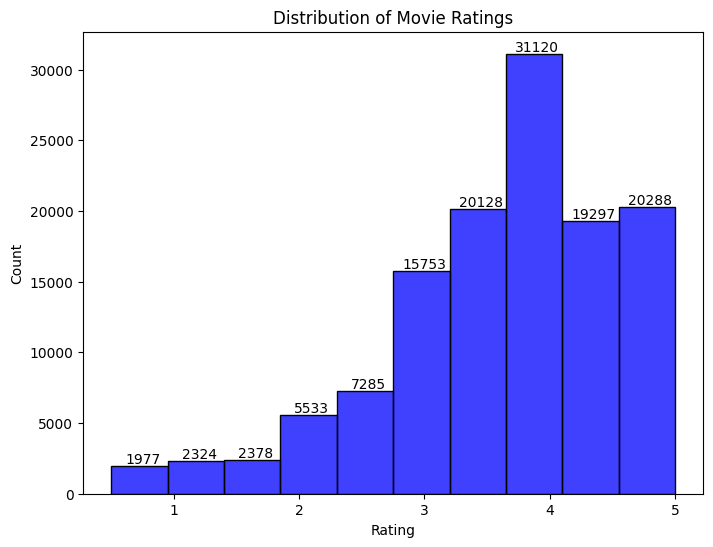

In [151]:
# visualize rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(merged_data['rating'], bins=10, kde=False, color='blue', kde_kws={'bw_adjust': 2})
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Add data labels for each bar
counts, bin_edges = np.histogram(merged_data['rating'], bins=10)
for count, x in zip(counts, bin_edges[:-1]):
    plt.text(x + 0.25, count + 200, str(int(count)), ha='center')
    
plt.show()

*Observation:* 
- The rating distribution is positively skewed.
- This indicates that most users tend to give higher ratings (close to 5) and fewer give very low ratings.
- This trend suggests that users generally rate movies they enjoy rather than those they dislike.

## 2.2 Genre Distribution Visualization
**This part of the visualization shows the distribution of movie types, helping us understand which types of movies are the most popular and which types are relatively unpopular. This can reveal what genres users prefer and whether there are major trends (for example, whether certain types of movies are always more popular). Understanding this genre distribution is crucial for the construction of content recommendation systems, especially when recommending genres that users are likely to like.**

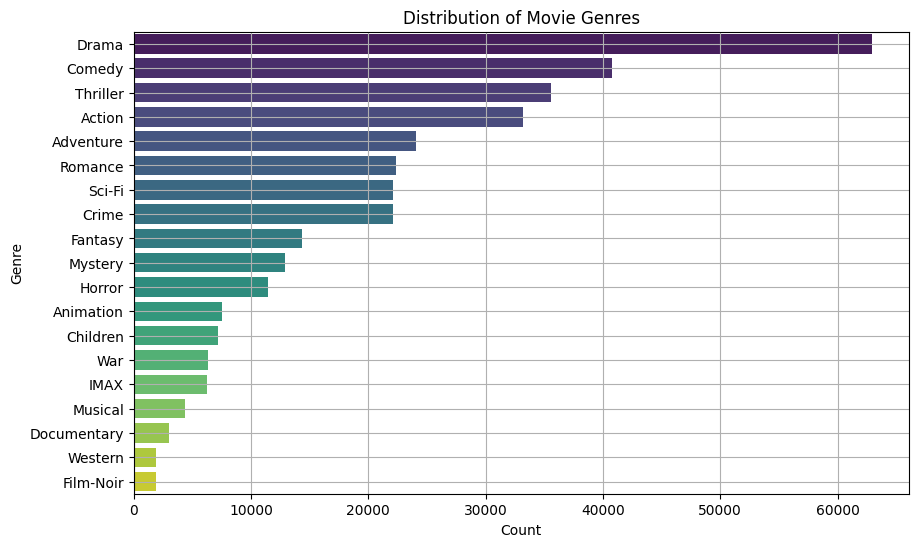

In [152]:
# split genres col, make each genre a list
merged_data['genres_split'] = merged_data['genres'].str.split('|')

# use explode to show genre as independent row and save the result as a new dataframe
genres_exploded = merged_data.explode('genres_split')

# filter out (no genres listed)
genres_exploded = genres_exploded[genres_exploded['genres_split'] != '(no genres listed)']

# count each genre's appearance
genre_counts = genres_exploded['genres_split'].value_counts()

# visualize genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')

plt.grid(True)
plt.show()

*Observation:*
- Drama is the most common genre, followed by Comedy, Thriller, and Action. 
- Less popular genres such as Film-Noir, Western, and Musical have significantly fewer movies.
- Understanding genre popularity will be helpful in building a genre-based recommendation system.

## 2.3 Ratings Per Year Visualization 
**By displaying the trend in the number of ratings per year, we can observe whether there are changes in user activity in different periods. For example, a sharp increase in ratings in certain years may mean that there were more popular movies that year, or that the emergence of certain platforms or services drove the increase in ratings. Understanding these patterns over time can help us predict future user behavior, as well as analyze the rise of certain movie genres or popular trends.**

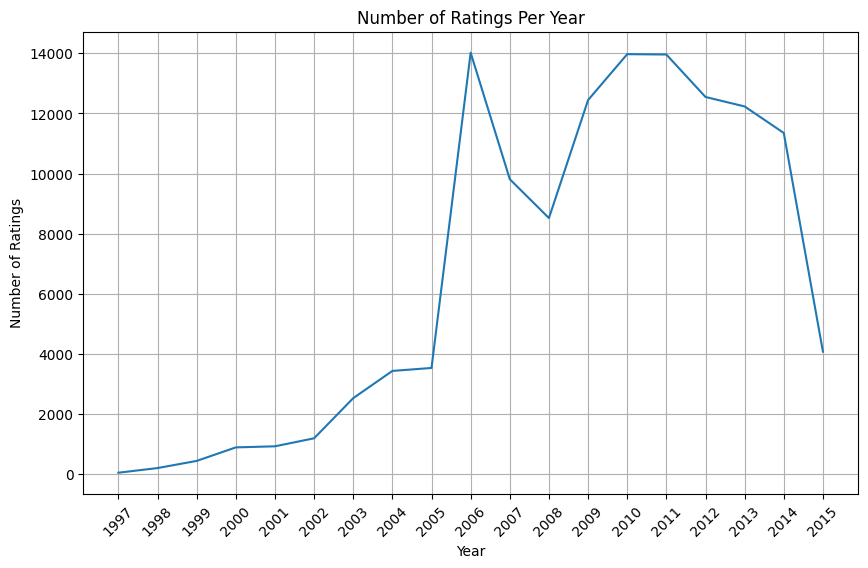

In [153]:
# convert timestamp to datetime format
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

# extract year and month
merged_data['year'] = merged_data['timestamp'].dt.year
merged_data['month'] = merged_data['timestamp'].dt.month

# calculate ratings based on year
ratings_per_year = merged_data.groupby('year').size()

# visualize
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_year.index, ratings_per_year.values)
plt.title('Number of Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')

# Set x-ticks to integers
plt.xticks(ticks=np.arange(ratings_per_year.index.min(), ratings_per_year.index.max() + 1, step=1), rotation=45)

plt.grid(True)
plt.show()

*Observation:*
- There's a sharp increase in the number of ratings between 2005 and 2006, followed by a decline after 2011.
- This could be due to changes in movie watching trends or the introduction of new movie platforms.
- Investigating this further could provide insights into user behavior over time.

## 2.4 Ratings Per User Visualization
**This graph shows the number of ratings given by each user, helping us understand user behavior patterns—whether the majority of users tend to rate many movies, or whether the majority of users rate only a few movies. This can reveal how many "active users" and "silent users" there are on the platform. Understanding these behavioral patterns is critical for building personalized recommendation systems, especially for the cold start problem or the design of collaborative filtering algorithms.**

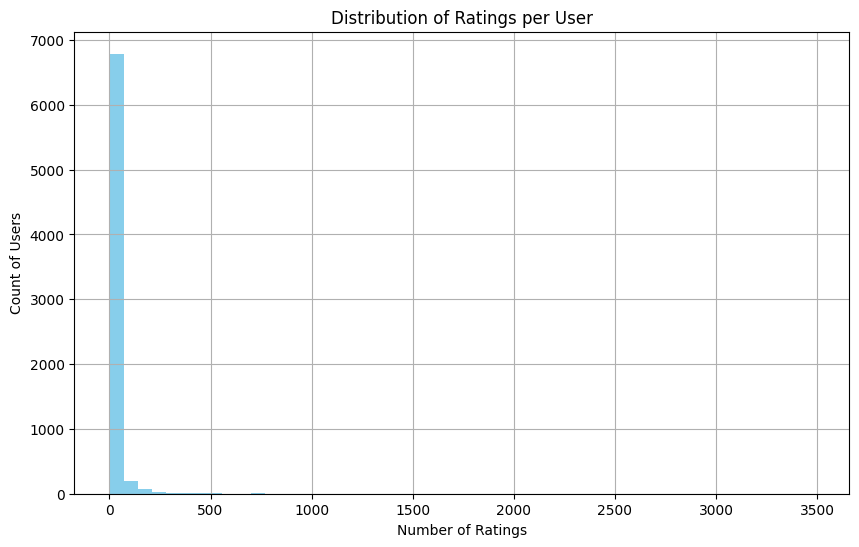

In [154]:
# count the number of ratings for each user 
user_rating_counts = merged_data.groupby('userId').size()

# visualize Distribution of Ratings per User
plt.figure(figsize=(10, 6))
plt.hist(user_rating_counts, bins=50, color='skyblue') ##### log=True???????????????????????????????????
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.grid(True)
plt.show()

*Observation:*
- A typical long-tail distribution where most users have rated fewer than 100 movies.
- A small percentage of highly active users contribute a disproportionately large number of ratings.
- This observation is important when selecting users for collaborative filtering models.

## 2.5 Ratings Per Movie Visualization 
**This graph shows the distribution of the number of ratings for each movie, helping us understand the movie's popularity. By identifying those movies with a large number of ratings, it is possible to determine which movies are popular, while also revealing niche movies (those with a small number of ratings). This information is particularly valuable for content recommendation systems and collaborative filtering systems, especially when providing different recommendation strategies for popular and less popular movies.**

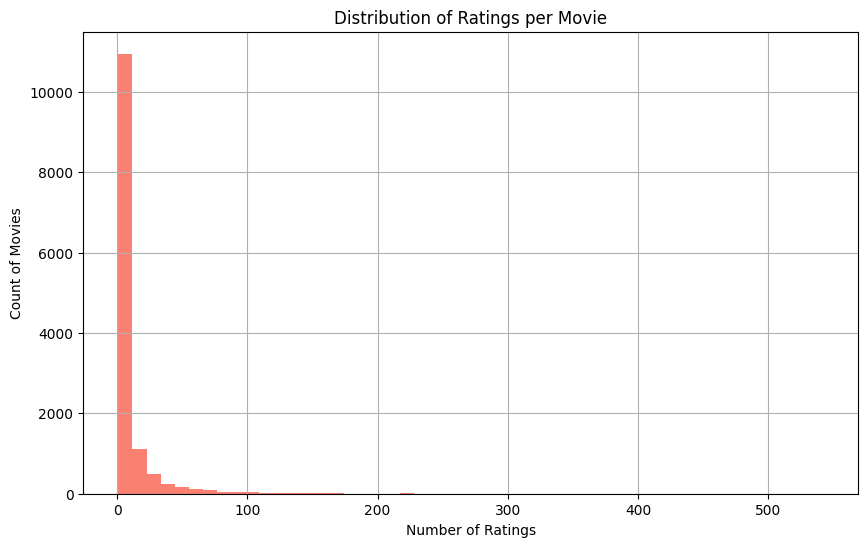

In [155]:
# Count the number of ratings for each movie
movie_rating_counts = merged_data.groupby('movieId').size()

# visualize 'Distribution of Ratings per Movie
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_counts, bins=50, color='salmon')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.grid(True)
plt.show()

*Observation:*
- Similar to user ratings, this is another long-tail distribution where most movies receive few ratings.
- A small number of popular movies receive the majority of ratings.
- This insight helps in understanding which movies are commonly rated, and may inform bias in model training.

## 2.6 The relationship between average ratings and years
**See how the average rating changes from year to year. This can help us observe whether movie ratings change over time, and whether movies from certain years are more popular or rated higher.**

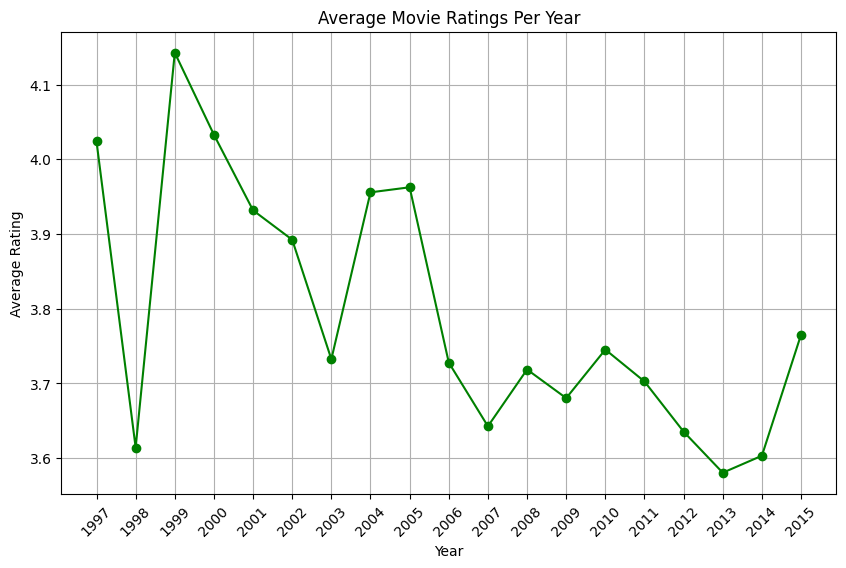

In [156]:
# calculate average ratings per year
average_ratings_per_year = merged_data.groupby('year')['rating'].mean()

# visualize average ratings per year
plt.figure(figsize=(10, 6))
plt.plot(average_ratings_per_year.index, average_ratings_per_year.values, marker='o', color='green')
plt.title('Average Movie Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)

# Set x-ticks to integers for better clarity
plt.xticks(ticks=np.arange(average_ratings_per_year.index.min(), average_ratings_per_year.index.max() + 1, step=1), rotation=45)

plt.show()


*Observations:*
- The average movie ratings exhibit fluctuations over the years, with notable peaks in 1999, 2005, - and 2015, where the average ratings surpassed 4.0.
- There are significant drops in 1998, 2003, and 2013, where the average rating falls below 3.7, indicating weaker years in terms of user ratings.
- The highest average rating occurs in 1999, where it reaches higher than 4.1, while the lowest average rating is observed in 2013.
- The trend from 2010 to 2014 shows relatively lower average ratings, with a recovery in 2015. 

## 2.7 Average Movie Ratings by Genre
**Further analysis of the relationship between movie genres and ratings. By calculating the average rating for each movie type, we can observe whether certain types of movies have a higher rating preference among viewers. This helps to understand audience attitudes towards different film types and whether there are certain types of films that consistently receive higher ratings.**

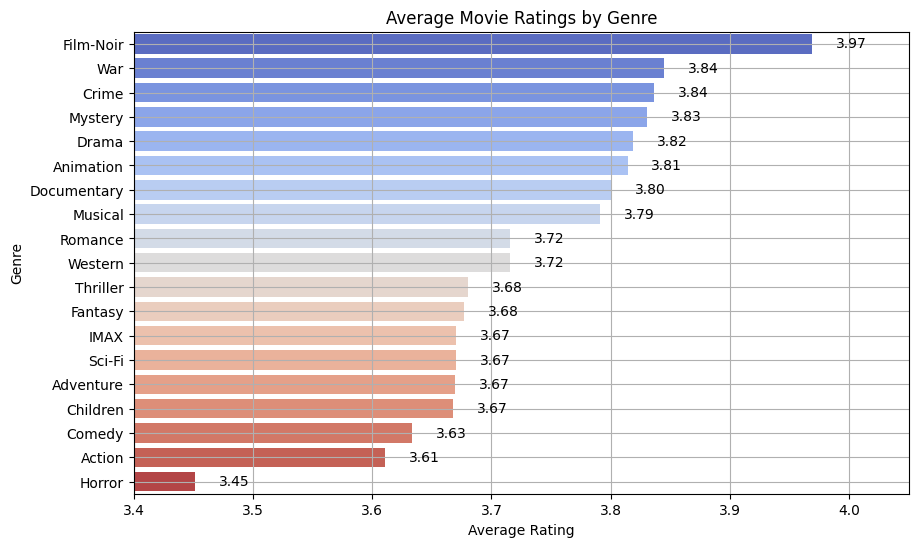

In [157]:
# calculate average rating per genre
average_ratings_per_genre = genres_exploded.groupby('genres_split')['rating'].mean().sort_values(ascending=False)

# visualize average rating per genre
plt.figure(figsize=(10, 6))
sns.barplot(x=average_ratings_per_genre.values, y=average_ratings_per_genre.index, palette='coolwarm')
plt.title('Average Movie Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')

# Add data labels to each bar
for i, (value, name) in enumerate(zip(average_ratings_per_genre.values, average_ratings_per_genre.index)):
    plt.text(value + 0.02, i, f'{value:.2f}', va='center')

plt.grid(True)
plt.xlim(3.4,4.05)
plt.show()

*Observations:*
- The genre *Film-Noir* has the highest average rating at 3.97, indicating that users generally rate movies from this genre very highly.
- Other top-rated genres include *War*, *Crime*, *Mystery*, and *Drama*, all with average ratings above 3.8.
- *Horror* has the lowest average rating, with a score of 3.45, suggesting it is less favored by users in comparison to other genres.
- Genres like *Action* and *Comedy* also have relatively lower average ratings, falling between 3.6 and 3.7.
- There is a noticeable gap between the highest-rated genres (such as *Film-Noir* and *War*) and the lowest-rated genres (*Horror*, *Action*), showing that user preferences tend to lean toward more serious and dramatic genres over lighthearted or thrilling content.

## Summary of Descriptive Analysis:
From the descriptive analysis, several key trends are observed in the data:
1. **Rating Distribution**: Users tend to give high ratings, with the majority of ratings clustered around 4 or 5. This implies users generally rate movies they enjoy, which may introduce some positive bias in recommendation systems.
2. **Genre Popularity**: Drama, Comedy, and Action dominate the dataset, while niche genres like Film-Noir and Western have significantly fewer ratings. Understanding these genre preferences will be important for building content-based or hybrid recommendation systems.
3. **User and Movie Rating Patterns**: Both user ratings and movie ratings follow a long-tail distribution, with most users rating few movies and most movies receiving few ratings. This suggests that collaborative filtering methods may need to focus on the more active users and more popular movies to generate meaningful recommendations.
4. **Average Ratings Over Time**: There is a fluctuation in average movie ratings over the years. A noticeable peak is seen in 1999 and 2005, while ratings appear to dip after 2011. This pattern could be influenced by changes in movie production, user preferences, or external events, and could inform temporal adjustments in recommendation algorithms.
5. **Genre and Ratings Correlation**: Certain genres tend to receive higher average ratings, with Film-Noir, War, and Crime leading, while Horror and Action are rated lower on average. This insight can be useful for understanding user preferences across different genres and fine-tuning content-based recommendation systems accordingly.

# Note on Inferential Analysis
In this project, we focused on building a robust recommendation system using collaborative filtering and content-based methods. Inferential analysis was not conducted because the primary goal is not to draw statistical inferences but to make accurate predictions. The emphasis is on optimizing the model's performance through machine learning techniques rather than testing hypotheses about the relationships between variables.

# 3. Model Preparation and Training

In [158]:
# Computing the sparsity of the rating matrix
total_possible_ratings = merged_data['userId'].nunique() * merged_data['movieId'].nunique()
actual_ratings = len(merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9987


The sparsity of the rating matrix is 0.9987, which means that 99.87% of user-movie pairs have no ratings, and only 0.13% of user-movie pairs have rating data. This shows that the dataset is very sparse, with relatively few ratings, and most users have not rated most movies.

In [159]:
# Filter out users who have rated less than 20 times
active_users = user_rating_counts[user_rating_counts >= 20].index
final_merged_data = merged_data[merged_data['userId'].isin(active_users)]

# Filter out movies with less than 50 ratings
popular_movies = movie_rating_counts[movie_rating_counts >= 50].index
final_merged_data = final_merged_data[merged_data['movieId'].isin(popular_movies)]

# Computing the sparsity of the rating matrix again
total_possible_ratings = final_merged_data['userId'].nunique() * final_merged_data['movieId'].nunique()
actual_ratings = len(final_merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9333


Sparsity got improved.

## 3.1 Label Encoding for userId and movieId

In [160]:
def encode_column(df, column_name):
    """Function to encode the categorical values in a given column using LabelEncoder"""
    encoder = LabelEncoder()
    df[f'{column_name}_encoded'] = encoder.fit_transform(df[column_name])
    return encoder

# Apply label encoding to 'userId' and 'movieId'
user_encoder = encode_column(final_merged_data, 'userId')
movie_encoder = encode_column(final_merged_data, 'movieId')

# Check data after label encoding
print(final_merged_data[['userId', 'userId_encoded', 'movieId', 'movieId_encoded']].head())

    userId  userId_encoded  movieId  movieId_encoded
22     129               0     2706              191
23     129               0     3556              219
26     129               0     4878              247
29     129               0     8641              323
38     129               0    80549              478


UserId and movieId are now encoded as userId_encoded and movieId_encoded, which are integer representations for more efficient model training.

## 3.2 SVD Model Training and Tuning

In [161]:
# Start the timer for measuring execution time
start_time = time.time()

# Define the rating scale and prepare the dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(final_merged_data[['userId_encoded', 'movieId_encoded', 'rating']], reader)

# Define the parameter grid for SVD
param_grid = {
    'n_factors': [50, 100],  # Reduce the number of factors
    'n_epochs': [20, 30],    # Reduce the number of epochs
    'lr_all': [0.005],       # Fix the learning rate to a single value
    'reg_all': [0.02]        # Fix the regularization parameter to a single value
}

# Perform GridSearchCV for parameter tuning (using Surprise's GridSearchCV)
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Fit GridSearchCV on the dataset
grid_search.fit(data)

# Output the best parameters based on RMSE
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters for SVD model:", grid_search.best_params['rmse'])

# Train the final model with the best parameters
best_svd = grid_search.best_estimator['rmse']
trainset = data.build_full_trainset()
best_svd.fit(trainset)

# Perform predictions on the test set (train/test split is done inside the GridSearchCV)
testset = trainset.build_anti_testset()
predictions = best_svd.test(testset)

# Evaluate the model performance using RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# End the timer and calculate the total execution time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

Best RMSE score: 0.8042455358969072
Best parameters for SVD model: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 0.4920
MAE:  0.3801
Total execution time: 6.37 seconds


The RMSE and MAE results show that the prediction error of the model is within a reasonable range, indicating that the performance of the model is good.

## 3.3 Generate Movie Recommendations

In [162]:
def get_user_based_recommendations(user_id, final_merged_data, svd_model, n_recommendations=5):
    """Generate movie recommendations for a specific user based on the SVD model."""
    
    # Build a dictionary of movie IDs and movie titles in advance to optimize search efficiency
    movie_id_to_title = dict(zip(final_merged_data['movieId_encoded'], final_merged_data['title']))
    
    # Get movies that the user has rated
    user_rated_movies = final_merged_data[final_merged_data['userId_encoded'] == user_id]['movieId_encoded'].values
    all_movies = final_merged_data['movieId_encoded'].unique()
    
    # Filter out movies that users have not rated
    unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]
    
    # Use SVD model to predict ratings and rank based on ratings
    movie_scores = []
    for movie_id in unrated_movies:
        prediction = svd_model.predict(user_id, movie_id)  
        movie_scores.append((movie_id, prediction.est))  
    
    # sort movies based on predicted scores
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)
    
    # Get the IDs of the first n recommended movies
    top_movie_ids = [movie_id for movie_id, score in movie_scores[:n_recommendations]]
    
    # Return movie title based on movie ID
    recommendations = [movie_id_to_title[movie_id] for movie_id in top_movie_ids]
    
    return recommendations
    
result = get_user_based_recommendations(user_id=100, final_merged_data=final_merged_data, svd_model=best_svd)
result

['Amelie (2001)',
 '12 Angry Men (1957)',
 'North by Northwest (1959)',
 'Memento (2000)',
 'Fight Club (1999)']

# 4. Content-Based Recommendation

In [88]:
# One-Hot encoding the 'genres' column
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(merged_data['genres_split'])

# convert the result of One-Hot to DataFrame and add it to the original dataset and ensure the indices match
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=merged_data.index)
merged_data = pd.concat([merged_data, genres_encoded_df], axis=1)

# delete the original genres column and genres_split coloumn
merged_data.drop(['genres', 'genres_split'], axis=1, inplace=True)
merged_data.head()

,userId,movieId,title,director,rating,timestamp,tag,year,month,(no genres listed),...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,65,27866,In My Father's Den (2004),unknown,4.0,2011-05-09 16:05:59,New Zealand,2011,5,0,...,0,0,0,0,0,0,0,0,0,0
1,65,48082,The Science of Sleep (2006),unknown,4.5,2011-05-09 16:26:19,"surreal, unusual",2011,5,0,...,0,0,0,0,0,1,0,0,0,0
2,65,58652,CJ7 (2008),unknown,5.0,2011-05-09 16:09:31,"cute, emotional, girls who play boys, Stephen ...",2011,5,0,...,0,0,0,0,0,0,1,0,0,0
3,96,106696,Frozen (2013),unknown,3.5,2014-03-29 12:48:07,"animation, beautiful, characters, Disney, femi...",2014,3,0,...,0,0,0,1,0,1,0,0,0,0
4,121,778,Trainspotting (1996),Danny Boyle,4.0,2011-03-23 04:00:30,"dark comedy, drugs, Nudity (Full Frontal - Not...",2011,3,0,...,0,0,0,0,0,0,0,0,0,0


## 4.1 Genre-Based Recommendation System

In [89]:
def recommend_movies_based_on_genres(movie_title, merged_data, n_recommendations=10):
    """
    Recommends movies based on genres similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie for which to recommend similar movies.
    merged_data (DataFrame): The DataFrame containing the merged movie data with one-hot encoded genres.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    List of tuples with recommended movie titles and their corresponding similarity scores.
    """
    
    # Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Also convert the input to lowercase
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    movie_id = merged_data[merged_data['title'] == original_matched_title]['movieId'].values[0]
        
    # Select numeric columns (assumed to be one-hot encoded genres)
    genre_columns = merged_data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Ensure the movie_id exists in the dataset
    if movie_id not in merged_data['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found in the dataset.")
    
    # Get the index and vector of the matched movie
    movie_idx = merged_data[merged_data['movieId'] == movie_id].index[0]
    movie_vector = merged_data.loc[movie_idx, genre_columns].values.reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, merged_data[genre_columns].values).flatten()
    
    # Get indices of the most similar movies (excluding itself)
    similar_indices = similarity_scores.argsort()[::-1][1:n_recommendations+1]
    
    # Collect recommended movies with scores
    recommended_movies = []
    seen_titles = set()  # Track already recommended titles
    for idx in similar_indices:
        movie_title = merged_data.iloc[idx]['title']
        similarity_score = similarity_scores[idx]  # Get the similarity score
        if movie_title not in seen_titles:
            seen_titles.add(movie_title)
            recommended_movies.append((movie_title, similarity_score))  # Append as a tuple (title, score)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break   
            
    # Filter out the matched movie itself from recommendations
    filtered_recommendations = [(title, score) for title, score in recommended_movies if title != original_matched_title]
    
    return filtered_recommendations[:n_recommendations]  # Return movie titles with similarity scores

# Test the function 
recommended_movies = recommend_movies_based_on_genres('love', merged_data)
recommended_movies

[('Darkon (2006)', 0.9999999698535511),
 ('Now You See Me (2013)', 0.9999998868345709),
 ('20 Feet from Stardom (2013)', 0.999999828122739),
 ('Interstellar (2014)', 0.9999995387764619),
 ('Only Lovers Left Alive (2013)', 0.9999995305408148),
 ('The Amazing Spider-Man 2 (2014)', 0.9999994892310935),
 ('The Raid 2: Berandal (2014)', 0.9999994839064545),
 ('Jean-Michel Basquiat: The Radiant Child (2010)', 0.9999992681178925),
 ('Looper (2012)', 0.9999988890099458),
 ('Django Unchained (2012)', 0.99999875993887)]

## 4.2 Tag-Based Recommendation System using TF-IDF

In [166]:
# Define stopwords and preprocess the 'tags' column
stop_words = set(stopwords.words('english'))

def preprocess_tags(text):
    # convert input to string
    if not isinstance(text, str):
        text = str(text)
    
    tags = text.split(',') 

    # Clean and process each tag
    cleaned_tags = []
    for tag in tags:
        tag = tag.strip()  # Remove leading/trailing spaces
        tag = tag.lower()  # Convert to lowercase
        tag = re.sub(r'[^\w\s]', '', tag)  # Remove special characters and punctuation
        tag = ' '.join([word for word in tag.split() if word not in stop_words])  # Remove stopwords

        # Append the cleaned tag to the list if it's not empty
        if tag:
            cleaned_tags.append(tag)

    # Remove duplicates by converting to a set
    unique_tags = list(set(cleaned_tags))
    cleaned_text = ', '.join(unique_tags)

    return cleaned_text

# Apply the function to 'tag' column
merged_data['tags_processed'] = merged_data['tag'].fillna('').apply(preprocess_tags)

# use TF-IDF to vectorize `tags` colomn 
tfidf = TfidfVectorizer(max_features=1000)
tags_tfidf_matrix = tfidf.fit_transform(merged_data['tags_processed'])

def recommend_movies_based_on_tags(movie_title, merged_data, tags_tfidf_matrix, n_recommendations=10):
    """
    Recommends movies based on tags similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data (DataFrame): The DataFrame containing the movie data with TF-IDF vectorized tags.
    tags_tfidf_matrix (ndarray): The TF-IDF matrix representing the tags of the movies.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of tuples with recommended movie titles and their corresponding similarity scores.
    """
    
    # Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    # Find the corresponding movie ID and index
    movie_id = merged_data[merged_data['title'] == original_matched_title]['movieId'].values[0]
    
    # Ensure the movie ID exists in the dataset
    if movie_id not in merged_data['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found.")
    
    # Get the index and vector of the target movie
    movie_idx = merged_data[merged_data['movieId'] == movie_id].index[0]
    movie_vector = tags_tfidf_matrix[movie_idx].reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, tags_tfidf_matrix).flatten()
    
    # Get indices of top similar movies (excluding itself), requesting more to handle duplicates
    similar_indices = similarity_scores.argsort()[::-1][1:(n_recommendations * 5)]  # Request more in case of duplicates
    
    # Collect recommended movie titles with similarity scores
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles
    
    for idx in similar_indices:
        movie_title = merged_data.iloc[idx]['title']
        similarity_score = similarity_scores[idx]  # Get the similarity score
        
        # Only add unique movie titles (skip duplicates and the original movie)
        if movie_title not in seen_titles and movie_title != original_matched_title:
            seen_titles.add(movie_title)
            recommended_movies.append((movie_title, similarity_score))  # Append as a tuple (title, score)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    # Ensure we return exactly the requested number of recommendations
    return recommended_movies[:n_recommendations]

# Test the function 
recommended_movies = recommend_movies_based_on_tags('mulan', merged_data, tags_tfidf_matrix)
recommended_movies

[('The Fault in Our Stars (2014)', 0.9999999999999998),
 ('The Jane Austen Book Club (2007)', 0.8196160492571403),
 ('Django Unchained (2012)', 0.8196160492571403),
 ('Walk on Water (2004)', 0.8196160492571403),
 ('Mud (2012)', 0.8196160492571403),
 ('Biutiful (2010)', 0.8196160492571403),
 ('Race to Witch Mountain (2009)', 0.6959181769228642),
 ('The Beaver (2011)', 0.6884340067491013),
 ('Contracted (2013)', 0.684922157763896),
 ('Titanic (1997)', 0.6776243151075321)]

## 4.3 Director-Based Recommendation System

In [168]:
def recommend_movies_by_director(movie_title, merged_data, n_recommendations=5):
    """
    Recommends movies by the same director, based on the input movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data (DataFrame): The DataFrame containing the movie data, including director information.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of recommended movies by the same director, or a message if no director is found.
    """
    
    # Find the movie title and get the corresponding director
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        return []

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title and corresponding director
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    director = merged_data[merged_data['title'] == original_matched_title]['director'].values[0]
    
    # Check if the director is found
    if director == 'unknown':
        return []

    # Recommend movies by the same director
    movies_by_director = merged_data[merged_data['director'] == director]
    
    # Exclude the original movie from recommendations
    movies_by_director = movies_by_director[movies_by_director['title'] != original_matched_title]
    
    # Collect unique recommendations
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles

    for title in movies_by_director['title']:
        if title not in seen_titles:
            seen_titles.add(title)
            recommended_movies.append(title)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    return recommended_movies[:n_recommendations]

# test the function
recommended_movies = recommend_movies_by_director('interstella', merged_data, n_recommendations=5)
recommended_movies

['The Dark Knight (2008)',
 'The Prestige (2006)',
 'Inception (2010)',
 'Memento (2000)',
 'Batman Begins (2005)']

## 4.4 Combined Recommendation System

In [94]:
def combined_recommendation(movie_title_or_id, merged_data, tags_tfidf_matrix, genre_weight=0.5, n_recommendations=5):
    """
    Combines recommendations based on genres, tags, and directors if applicable.
    
    Parameters:
    movie_title_or_id (str or int): The title of the movie or user ID to search.
    merged_data (DataFrame): The DataFrame containing the movie data, including genres, tags, and director information.
    tags_tfidf_matrix (ndarray): The TF-IDF matrix representing the tags of the movies.
    genre_weight (float): The weight to apply to genre-based recommendations.
    tag_weight (float): The weight to apply to tag-based recommendations.
    n_recommendations (int): The number of similar movie recommendations to return (default is 5).
    
    Returns:
    A list of recommended movie titles.
    """
    
    tag_weight = 1 - genre_weight
    
    # Initialize variables to store recommendations
    genre_similar_movies = []
    tag_similar_movies = []
    director_recommendations = []

    # Get genre-based and tag-based recommendations
    genre_similar_movies = recommend_movies_based_on_genres(movie_title_or_id, merged_data, 10)  # Get 10 from genre function
    tag_similar_movies = recommend_movies_based_on_tags(movie_title_or_id, merged_data, tags_tfidf_matrix, 10)  # Get 10 from tag function

    # Get director-based recommendations if available (list of movie titles)
    director_recommendations = recommend_movies_by_director(movie_title_or_id, merged_data, n_recommendations=2)

    # Combine recommendations (starting with director-based if available)
    combined_recommendations = []

    # Prioritize director recommendations (1 or 2 movies)
    num_director_movies = min(2, len(director_recommendations))  # Take 1 or 2 movies from director recommendations
    combined_recommendations.extend(director_recommendations[:num_director_movies])

    # Calculate the remaining number of movies to pick from genre and tag recommendations
    remaining_slots = n_recommendations - len(combined_recommendations)  # Remaining slots after picking director movies
    
    # Calculate how many movies to take from genre and tag recommendations based on the weights
    num_genre_movies = math.ceil(genre_weight * remaining_slots)  # Number of movies to take from genre recommendations
    num_tag_movies = remaining_slots - num_genre_movies  # The rest will be from tag recommendations

    # Add movies from genre and tag recommendations (without duplicates)
    genre_movies_to_add = [movie for movie, _ in genre_similar_movies if movie.lower() not in [m.lower() for m in combined_recommendations]][:num_genre_movies]
    combined_recommendations.extend(genre_movies_to_add)

    tag_movies_to_add = [movie for movie, _ in tag_similar_movies if movie.lower() not in [m.lower() for m in combined_recommendations]][:num_tag_movies]
    combined_recommendations.extend(tag_movies_to_add)

    # Return only the movie titles, ensuring there are exactly `n_recommendations`
    return combined_recommendations[:n_recommendations]

# Example usage:
result = combined_recommendation('love', merged_data, tags_tfidf_matrix, genre_weight=0.9, n_recommendations=5)
result

['Darkon (2006)',
 'Now You See Me (2013)',
 '20 Feet from Stardom (2013)',
 'Interstellar (2014)',
 'Only Lovers Left Alive (2013)']

## 4.5 Gradio Interface for Movie Recommendation System

In [193]:
def recommend_interface(user_input, genre_weight=0.5):
    try:
        # Try to parse the input as a user ID
        user_id = int(user_input)
        # Use SVD-based recommendation for user ID
        recommendations = get_user_based_recommendations(user_id, final_merged_data, best_svd, n_recommendations=5)
        return "\n".join(recommendations)
    except ValueError:
        # When input is a movie title, use combined recommendation
        movie_title = user_input
        try:
            # Call the combined recommendation function
            recommendations = combined_recommendation(movie_title, merged_data, tags_tfidf_matrix, genre_weight=genre_weight, n_recommendations=5)
            
            if recommendations:
                # Return only the movie titles, no need to return the scores
                return "\n".join(recommendations)
            else:
                return "Oops, no movie found with a title similar to '{}'.".format(movie_title)
        except ValueError:
            return "Oops, no movie found with a title similar to '{}'.".format(movie_title)

# Create Gradio interface with a slider to adjust genre and tag weights
interface = gr.Interface(
    fn=recommend_interface,
    inputs=[
        gr.Textbox(label="Enter User ID or Movie Title"),
        gr.Slider(
            label="Weight:",
            minimum=0, 
            maximum=1, 
            value=0.5, 
            step=0.1,
            info="Vibe to the left, genre to the right:)"
        )
    ],
    outputs=gr.Textbox(label="Recommended Movies"),
    title="Charlotte's Movie Recommendation System 1.0",
    description="Enter a User ID for personalized recommendations, or a movie title for content-based recommendations. Adjust the slider for more tag-based or genre-based results."
)

# Launch the Gradio interface
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://27401f873edf27ab81.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Summary of Pre-Neural Network Phase:

At this stage, a hybrid recommendation system (Version 1.0) has been implemented, combining SVD-based collaborative filtering and content-based methods, such as genre, tags, and director-based recommendations. The system is further enhanced with a user-friendly Gradio interface, allowing users to adjust the balance between genre- and tag-based recommendations via a slider.

However, after extensive testing, it has become evident that while this system provides reasonable recommendations, several limitations persist, particularly in the content-based recommendation aspect. The genre and tag similarity metrics, though useful, sometimes fail to capture the full depth of a movie’s content. For instance, relying on textual features like tags and genres may overlook deeper thematic connections or more nuanced user preferences that are not easily captured by simple cosine similarity or one-hot encoding.

As a result, it has been recognized that there is significant room for improvement, especially in how the system understands and represents movie content. To address these limitations and further enhance the accuracy and relevance of the recommendations, more advanced methods, particularly neural networks and transformers, will be explored. These techniques are expected to better capture the complex relationships between users and movies, ultimately leading to a more sophisticated and personalized recommendation system (Version 2.0).

# Neural Network First Attempt: Combining Collaborative Filtering and Content-Based Features

## 1. Data Preprocessing  
The dataset is prepared by encoding various features, such as userId, movieId, genres, director, and tags using appropriate encoding techniques:
- Label Encoding: Applied to userId, movieId, and director to convert categorical data into numerical labels.
- One-Hot Encoding: Used for genres with the MultiLabelBinarizer to represent genres as binary vectors.
- TF-IDF Encoding: Applied to the tags column to extract the most important words for each movie description and build a TF-IDF matrix.
 
This preprocessing allows the neural network to process categorical and textual information efficiently.

In [169]:
# Label encoding
user_encoder = LabelEncoder()
merged_data_copy['userId_encoded'] = user_encoder.fit_transform(merged_data_copy['userId'])

movie_encoder = LabelEncoder()
merged_data_copy['movieId_encoded'] = movie_encoder.fit_transform(merged_data_copy['movieId'])

director_encoder = LabelEncoder()
merged_data_copy['director_encoded'] = director_encoder.fit_transform(merged_data_copy['director'])

# One-hot encoding for genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(merged_data_copy['genres'].str.split('|'))

# TF-IDF encoding for tags
tfidf = TfidfVectorizer(max_features=1000)
tags_tfidf_matrix = tfidf.fit_transform(merged_data_copy['tag'].fillna(''))

# Prepare training data
X_train = [
    merged_data_copy['userId_encoded'].values, 
    merged_data_copy['movieId_encoded'].values, 
    genres_encoded, 
    merged_data_copy['director_encoded'].values, 
    tags_tfidf_matrix.toarray()
]
y_train = merged_data_copy['rating'].values

## 2. Model Architecture: Initial Neural Network Design
This model is designed to predict movie ratings by combining collaborative filtering (user and movie embeddings) and content-based features (genres, directors, and tags). The model uses embeddings to represent userId, movieId, and directorId, one-hot encoding for genres, and a TF-IDF matrix for movie tags.

Key Components:
- Embedding layers for userId, movieId, and directorId, transforming these categorical features into dense vectors.
- Dense layers with ReLU activation for non-linear transformations.
- Dropout layers to prevent overfitting.
- Mean Squared Error (MSE) as the loss function and Mean Absolute Error (MAE) as the evaluation metric.

In [170]:
# Get the maximum user and movie ID of the data
num_users = merged_data_copy['userId_encoded'].nunique()
num_movies = merged_data_copy['movieId_encoded'].nunique()
num_directors = merged_data_copy['director_encoded'].nunique()

# Define embedding size
embedding_size = 50

# User, Movie, Director Embedding Layers
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
user_vector = Flatten(name='user_vector')(user_embedding)

movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)
movie_vector = Flatten(name='movie_vector')(movie_embedding)

director_input = Input(shape=(1,), name='director_input')
director_embedding = Embedding(input_dim=num_directors, output_dim=embedding_size, name='director_embedding')(director_input)
director_vector = Flatten(name='director_vector')(director_embedding)

# Genre and Tag Input Layers
genre_input = Input(shape=(genres_encoded.shape[1],), name='genre_input')
tag_input = Input(shape=(tags_tfidf_matrix.shape[1],), name='tag_input')

# Concatenate all features
merged = Concatenate(name='merged_layer')([user_vector, movie_vector, genre_input, director_vector, tag_input])

# Dense layers with Dropout to prevent overfitting
dense_1 = Dense(128, activation='relu')(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)

# Output layer
output = Dense(1, activation='linear', name='output')(dropout_2)

# build model
model = Model(inputs=[user_input, movie_input, genre_input, director_input, tag_input], outputs=output)

# compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# chech summary
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │    357,950 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │    669,800 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_embedding  │ (None, 1, 50)     │     17,450 │ director_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_vector         │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_vector        │ (None, 50)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_vector     │ (None, 50)        │          0 │ director_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_input           │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_layer        │ (None, 1170)      │          0 │ user_vector[0][0… │
│ (Concatenate)       │                   │            │ movie_vector[0][… │
│                     │                   │            │ genre_input[0][0… │
│                     │                   │            │ director_vector[… │
│                     │                   │            │ tag_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │    149,888 │ merged_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 64)        │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,203,409 (4.59 MB)

 Trainable params: 1,203,409 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

The model architecture integrates multiple features to predict movie ratings based on both collaborative filtering and content-based methods. Here's a breakdown of the key layers:
- Embedding layers for user, movie, and director: These layers learn dense vector representations for user IDs, movie IDs, and director IDs, helping the model capture latent relationships in a lower-dimensional space.
- One-hot encoded genre input and TF-IDF encoded tags input: These features provide additional content-based information, allowing the model to utilize categorical (genres) and textual (tags) data for more accurate predictions.
- The concatenated layer merges the different inputs, allowing the network to learn from both user-item interactions (via embeddings) and movie content (via genres and tags).
- The dense layers with ReLU activation capture nonlinear patterns in the combined feature set, while the dropout layers help prevent overfitting by randomly disabling neurons during training.

The final output layer predicts the movie rating as a continuous value using a linear activation function. The model is optimized using mean squared error (MSE) as the loss function and Adam optimizer for efficient gradient updates.

## 3. Training the Model
The model is trained with the following parameters:
- Learning Rate: 0.001
- Batch Size: 32
- Epochs: 10
- Validation Split: 0.2 (20% of the data is reserved for validation)

Final Training Loss: 0.4155, Final Training MAE: 0.4583
Final Validation Loss: 0.9572, Final Validation MAE: 0.7549


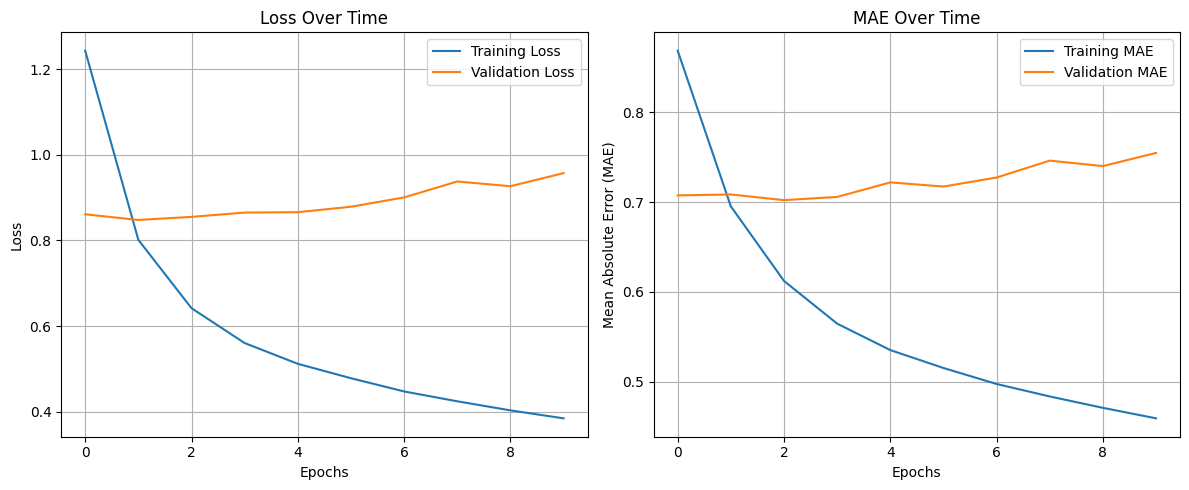

In [171]:
# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# show results
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss = history.history['val_loss'][-1]
val_mae = history.history['val_mae'][-1]
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")

# visualize model loss and MAE
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # plot training and validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_history(history)

The model shows signs of overfitting. Training loss and MAE decrease, but validation loss and MAE fluctuate, indicating poor generalization.

## 5. Model Refinement Attempts
Several techniques were applied to reduce overfitting and improve model performance, including:
- Reducing Neurons: Simplifying the model by reducing the number of neurons in the dense layers.
- Learning Rate Adjustments: Lowering the learning rate to allow the model to learn more slowly and avoid overfitting.
- Adding L2 Regularization: To penalize large weights and reduce overfitting.
- Increasing Dropout Rate: To further reduce overfitting by forcing the model to generalize better.

Final Training Loss: 0.4667, Final Training MAE: 0.4957
Final Validation Loss: 0.4667, Final Validation MAE: 0.4957


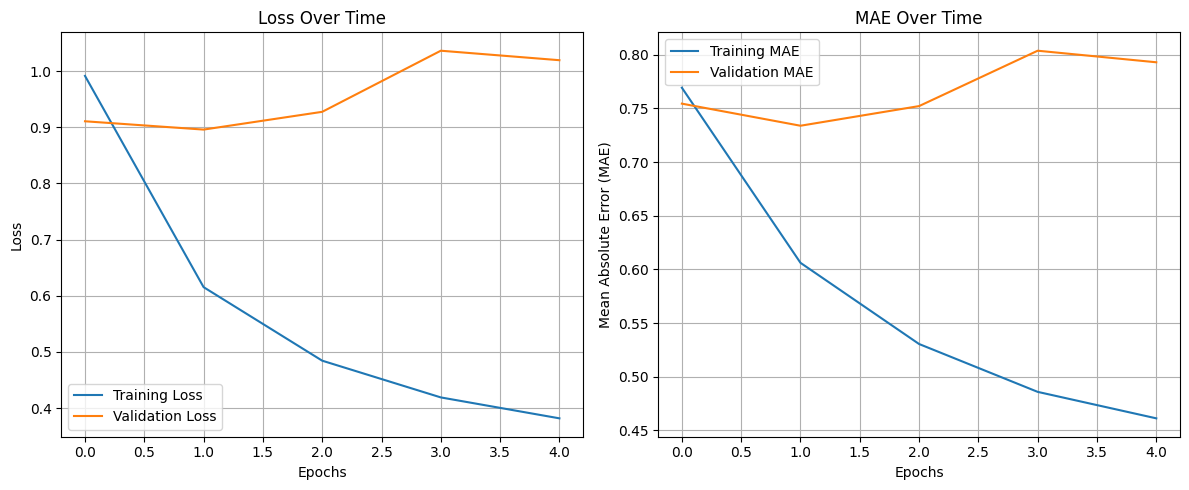

In [172]:
# repeat steps above but add earlystopping
dense_1 = Dense(128, activation='relu')(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model = Model(inputs=[user_input, movie_input, genre_input, director_input, tag_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping is used to halt training if the validation loss does not improve after 3 epochs, helping avoid overfitting.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # add earlystopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After adding Early Stopping, the model stopped training early (after about 3 epochs). The training loss and MAE improved steadily, but the validation loss and MAE continue to increase. This indicates that while the model is learning effectively on the training data, it still suffers from overfitting, as the validation performance worsens as training progresses.

Final Training Loss: 0.4458, Final Training MAE: 0.4833
Final Validation Loss: 0.4458, Final Validation MAE: 0.4833


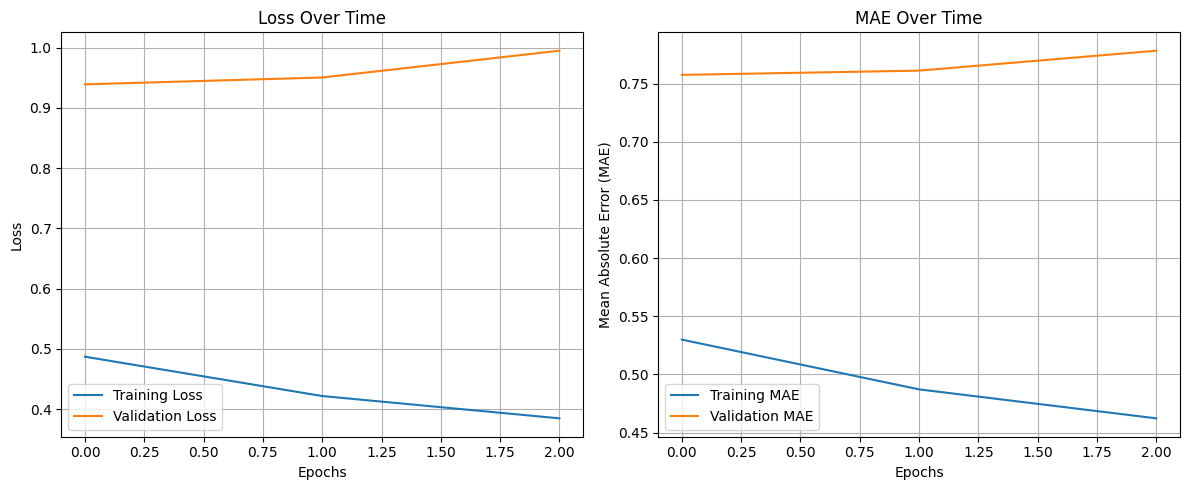

In [173]:
# reduce neurons to reduce overfitting
dense_1 = Dense(64, activation='relu')(merged)  # reduce to 64 neurons
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)  # reduce to 32 neurons
dropout_2 = Dropout(0.5)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After reducing the number of neurons in the model, the loss and MAE of the training set continue to decrease, but the loss and MAE of the validation set have almost no change and remain at a high level from the beginning of training. Although the model performed well on the training set, its performance on the validation set was still not ideal, and there were still signs of overfitting.

Final Training Loss: 0.4225, Final Training MAE: 0.4619
Final Validation Loss: 0.4225, Final Validation MAE: 0.4619


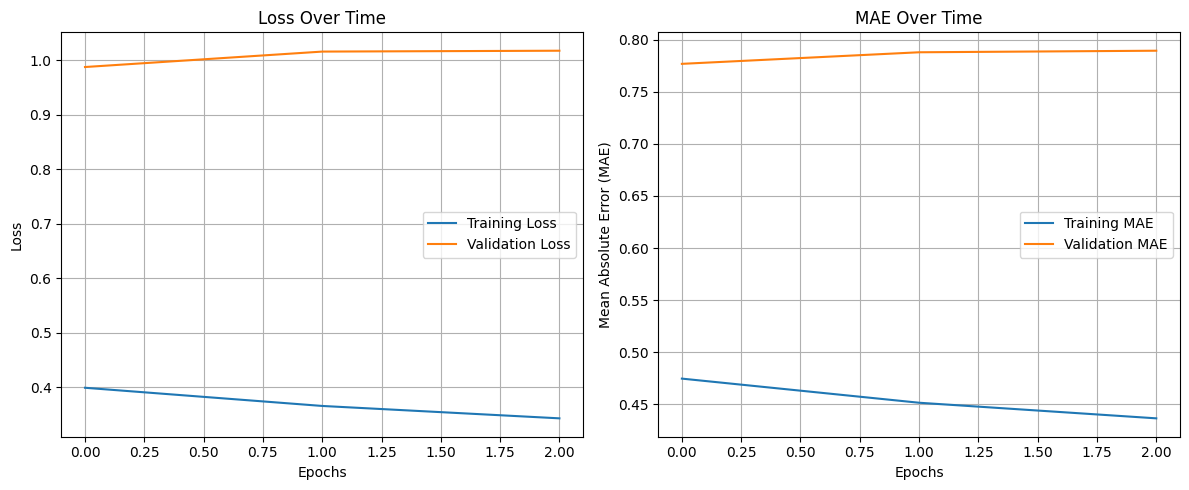

In [174]:
# reduce learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After reducing the learning rate, the loss and MAE of the training set further decreased, but the loss and MAE of the validation set hardly improved and remained at a high level from the beginning, and the performance of the validation set did not follow the improvement of the training set. This still shows that the model's generalization ability on the validation set is not strong, and the loss and MAE of the validation set have not declined from the beginning.

Final Training Loss: 0.4135, Final Training MAE: 0.4583
Final Validation Loss: 0.4135, Final Validation MAE: 0.4583


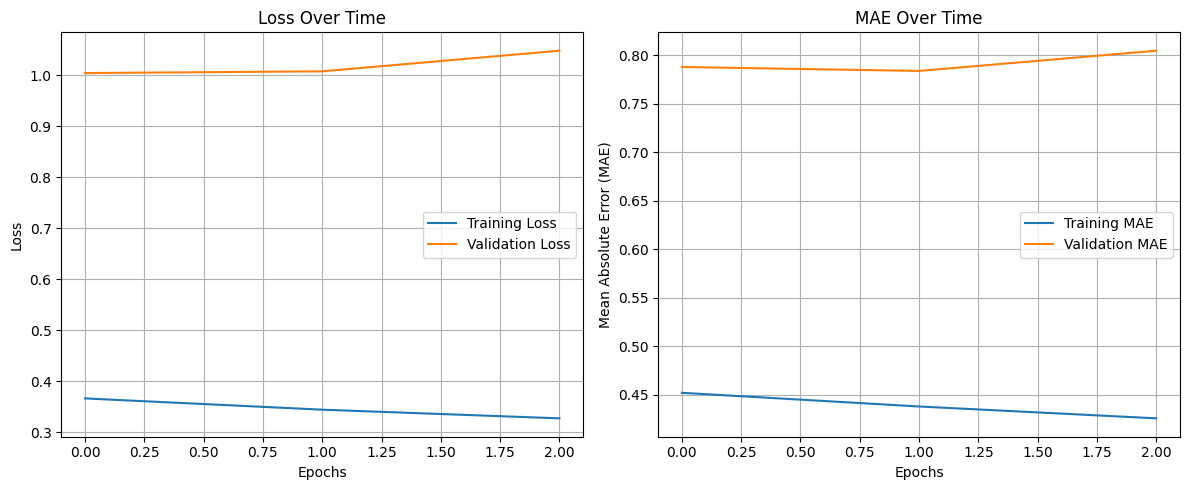

In [175]:
# add regularization
dense_1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After adding L2 regularization, the training loss and MAE decreased again, but the validation set loss and MAE remained the same and remained at a high level from the beginning of training. This shows that L2 regularization plays a certain role in the training set, but fails to improve the generalization ability on the verification set, and the model still overfits on the verification set.

Final Training Loss: 0.4120, Final Training MAE: 0.4530
Final Validation Loss: 0.4120, Final Validation MAE: 0.4530


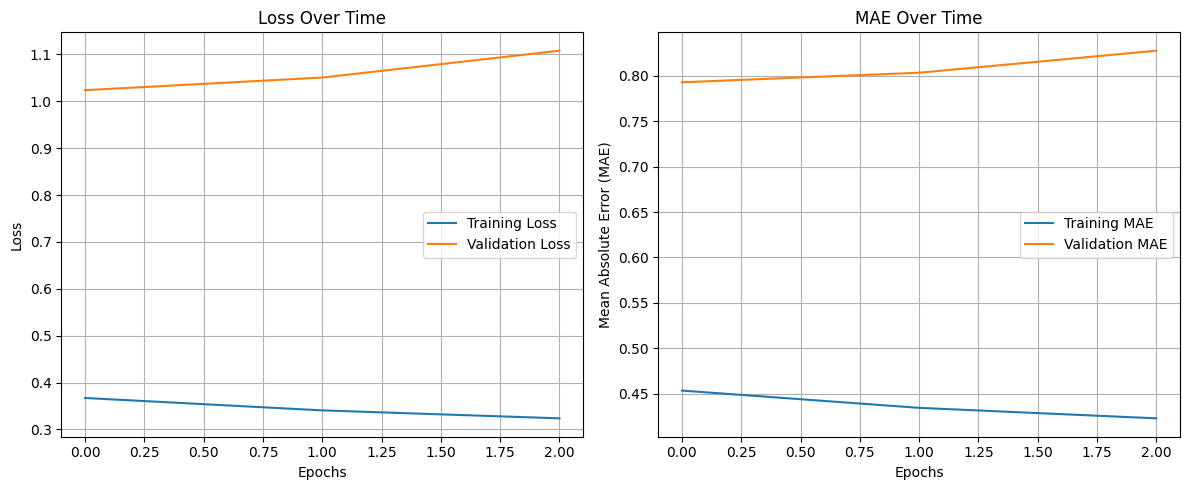

In [105]:
# increase dropout rate
dense_1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

After increasing the Dropout ratio, the loss and MAE of the training set decreased slightly, but the loss and MAE of the verification set still did not improve significantly. The loss and MAE of the validation set still remain at a high level, indicating that the model is still significantly overfitting.

Final Training Loss: 0.4100, Final Training MAE: 0.4509
Final Validation Loss: 0.4100, Final Validation MAE: 0.4509


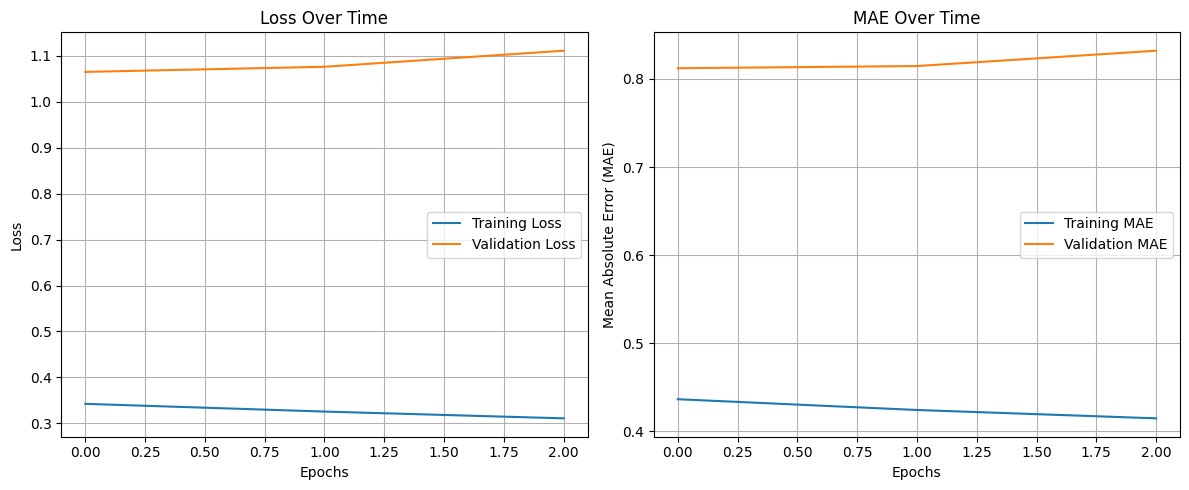

In [106]:
# reduce neurons again
dense_1 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
output = Dense(1, activation='linear', name='output')(dropout_2)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=0)
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Training Loss: {train_loss:.4f}, Final Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate(X_train, y_train, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation MAE: {val_mae:.4f}")
plot_history(history)

The results after reducing neurons show that the loss and MAE of the training set continue to decrease, but the loss and MAE of the validation set still remain at a high level. Although the model has become simpler, the performance on the validation set still has not improved, indicating that the model still has the problem of insufficient generalization ability.

## Summary on first Neural Network attempt:
**After conducting the first neural network and tuning various hyperparameters, the results did not show significant improvement. Despite multiple adjustments, such as reducing the learning rate, adding dropout layers, and implementing L2 regularization, the model continued to struggle with overfitting, and its validation performance remained unsatisfactory. As a result, a new neural network architecture will be explored in the next attempt to enhance the model’s generalization ability and overall performance.**

# Neural Network Second Attempt

After the first neural network attempt, where the performance plateaued despite extensive tuning, this second attempt adopts a slightly different approach. Instead of handling user and movie IDs directly within the model, the focus is now on optimizing the neural network for content-based features such as genres and tags, with the goal of improving recommendations.

## 1. Preprocessing Genre and Tag Data

Similar to the previous neural network, preprocessing the genres using one-hot encoding and the tags using TF-IDF. These preprocessed features are then fed directly into the neural network.

In [176]:
# Input layers for genres and tags
genre_input = Input(shape=(genres_encoded.shape[1],), name='genre_input')
tag_input = Input(shape=(tags_tfidf_matrix.shape[1],), name='tag_input')

## 2. Building the Neural Network Model
The neural network architecture is relatively simple, with two dense layers followed by dropout layers to prevent overfitting. The idea is to combine both genre and tag information and pass them through fully connected layers for rating prediction.

In [177]:
# Build the neural network model
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(64, activation='relu')(merged)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

## 3. Training the Model with Early Stopping
Train the model on the preprocessed genre and tag data using Adam optimizer and mean_squared_error as the loss function. Early stopping is applied to avoid overfitting, allowing us to monitor validation loss and restore the best weights.

Training Loss: 0.7253, Training MAE: 0.6534
Validation Loss: 0.8213, Validation MAE: 0.6955


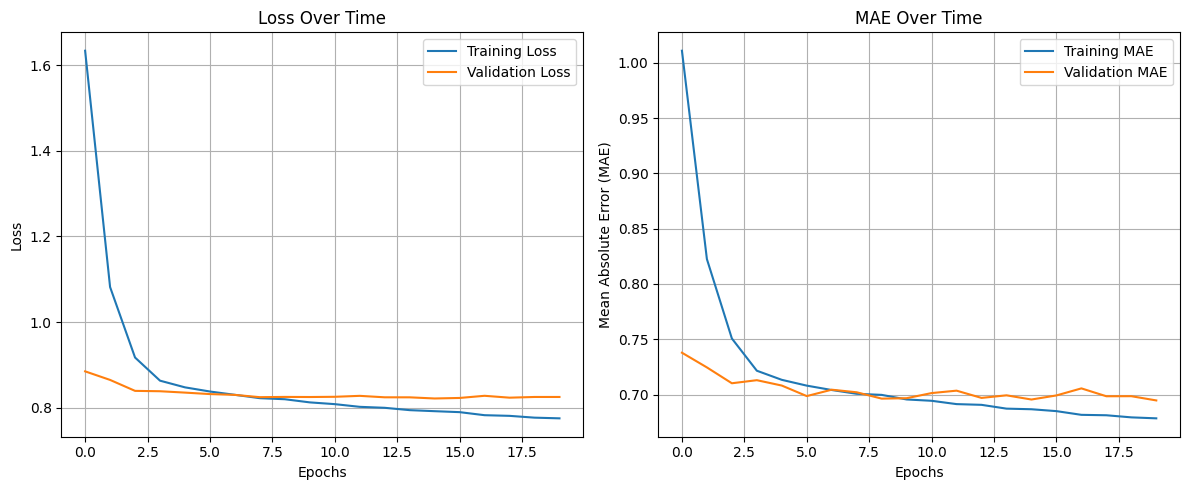

In [178]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# define target
y = merged_data_copy['rating'].values  

# split genres and tags 
X_train_genre, X_val_genre, X_train_tag, X_val_tag, y_train, y_val = sk_train_test_split(
    genres_encoded,  # genres
    tags_tfidf_matrix.toarray(),  # tags
    y,  
    test_size=0.2,  
    random_state=42)

# Train the model
history = model.fit(
    [X_train_genre, X_train_tag],  # Inputs
    y_train,  # Target (ratings)
    epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=([X_val_genre, X_val_tag], y_val),  # Validation data
    callbacks=[early_stopping],  # EarlyStopping callback
    verbose=0 
)

# Evaluate the model on the training set
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")

# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

# Plot history
plot_history(history)

Judging from the performance of the training set, the model is obviously gradually learning more features.
However, the loss on the validation set did not drop as significantly as the training set, which means that although the model performed well on the training set, there was still a large error on the validation set (loss of 0.8189 and MAE of 0.6964) , need further optimization.

## 4. Model Refinement Attempts

Training Loss: 0.7326, Training MAE: 0.6571
Validation Loss: 0.8189, Validation MAE: 0.6965


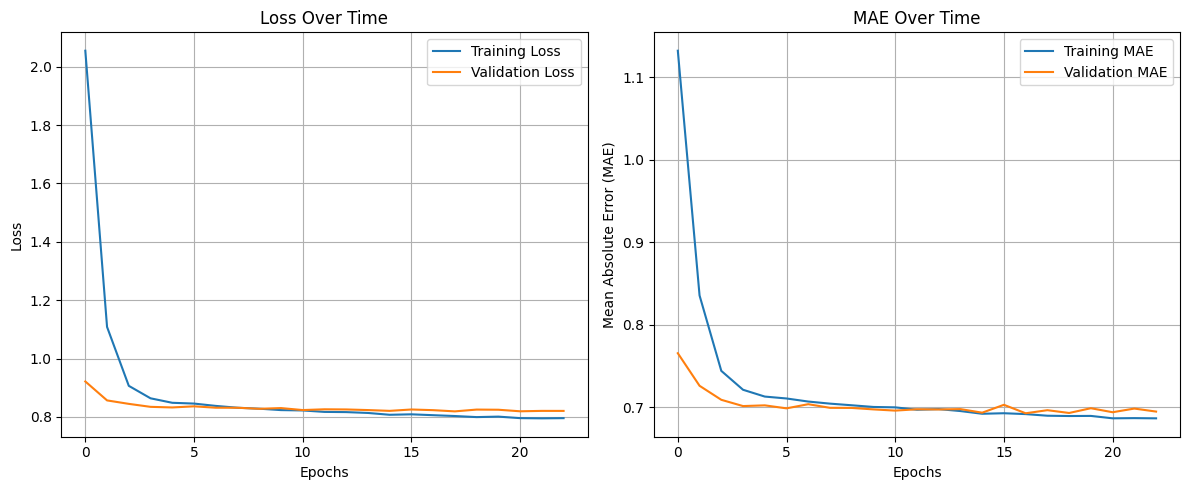

In [179]:
# repeat the steps above but increase dropout rate
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(64, activation='relu')(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_genre, X_train_tag], 
    y_train,  
    epochs=50, 
    batch_size=32,  # Batch size
    validation_data=([X_val_genre, X_val_tag], y_val),  
    callbacks=[early_stopping],  
    verbose=0 
)
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
plot_history(history)

Although the model did not suffer from serious overfitting after adding Dropout, the performance of the validation set did not improve significantly, indicating that simply adding Dropout may not be enough.

Training Loss: 0.7442, Training MAE: 0.6621
Validation Loss: 0.8223, Validation MAE: 0.6970


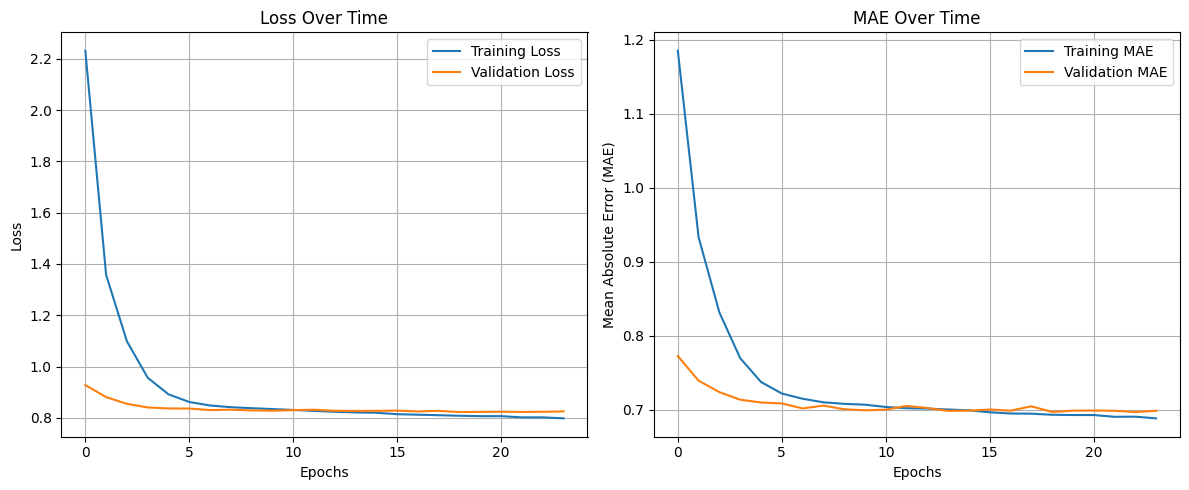

In [180]:
# repeat the steps above but lower learning rate
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(64, activation='relu')(merged)
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.6)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])# lower lr
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_genre, X_train_tag], 
    y_train,  
    epochs=50, 
    batch_size=32,  
    validation_data=([X_val_genre, X_val_tag], y_val), 
    callbacks=[early_stopping], 
    verbose=0 
)
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
plot_history(history)

The loss and MAE of the validation set are almost the same as those of the training set, indicating that the overfitting phenomenon has been reduced and the model's generalization ability on the validation set has been improved.
Although the Loss and MAE of the validation set did not drop significantly, they at least remained in a relatively stable state without obvious overfitting.

Training Loss: 0.7948, Training MAE: 0.6872
Validation Loss: 0.8387, Validation MAE: 0.7058


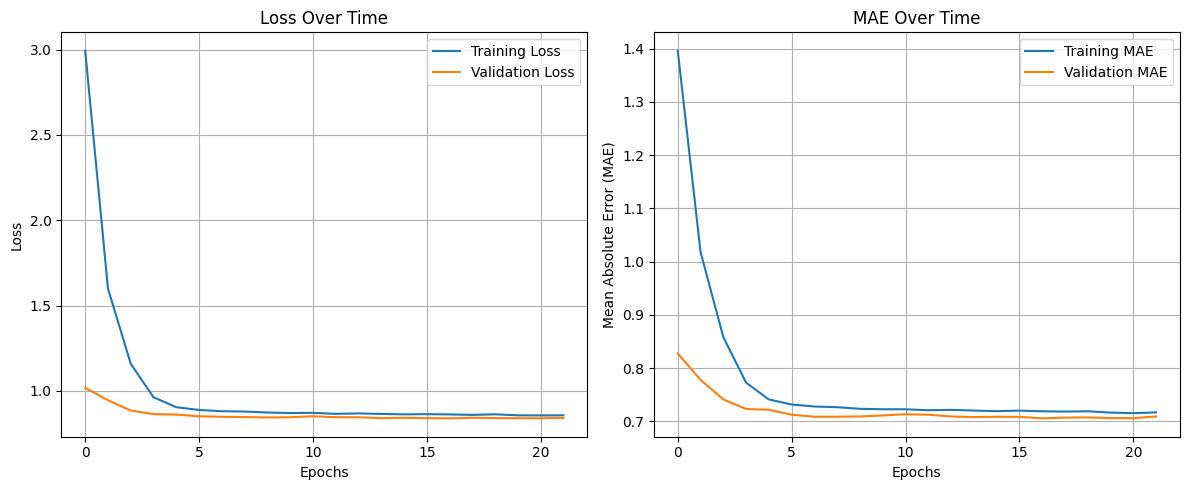

In [181]:
# repeat the steps above but reduce neurons 
merged = Concatenate(name='merged_layer')([genre_input, tag_input])
dense_1 = Dense(32, activation='relu')(merged) # reduce neurons
dropout_1 = Dropout(0.6)(dense_1)
dense_2 = Dense(16, activation='relu')(dropout_1) # reduce neurons
dropout_2 = Dropout(0.6)(dense_2)
nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)
model = Model(inputs=[genre_input, tag_input], outputs=nn_output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])# lower lr
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [X_train_genre, X_train_tag], 
    y_train,  
    epochs=50, 
    batch_size=32,  
    validation_data=([X_val_genre, X_val_tag], y_val), 
    callbacks=[early_stopping], 
    verbose=0 
)
train_loss, train_mae = model.evaluate([X_train_genre, X_train_tag], y_train, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
plot_history(history)

Since the validation loss and validation MAE are very close to the trained ones, this shows that the model not only fits the training set well, but also performs very stably on the validation set.

## 5. KFold Cross-Validation

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


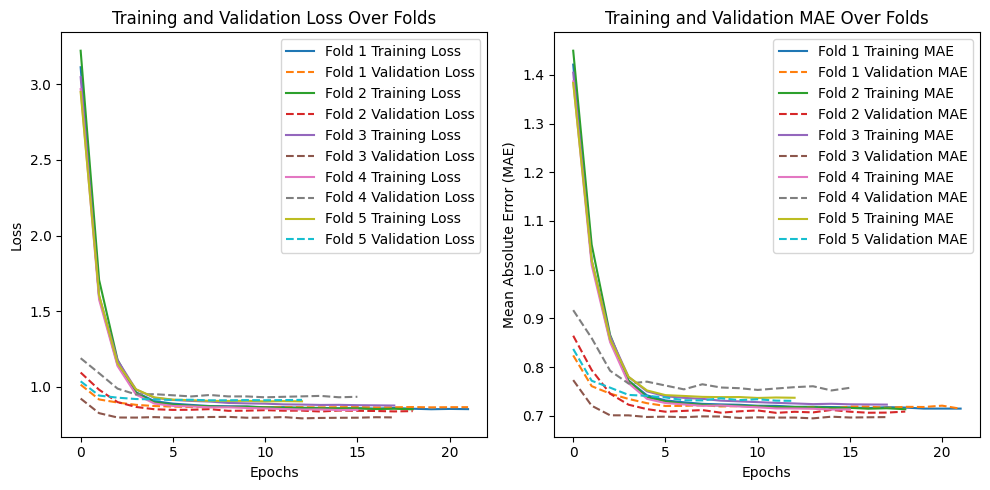

Average Validation Loss: 0.8665271401405334
Average Validation MAE: 0.7213330268859863


In [182]:
# Define KFold with 5 splits
kf = KFold(n_splits=5)

# Lists to store evaluation metrics for each fold
val_losses = []
val_maes = []

# Lists to store loss and MAE history for all folds
train_loss_history = []
val_loss_history = []
train_mae_history = []
val_mae_history = []

# Loop through each fold
fold_no = 1
for train_index, val_index in kf.split(genres_encoded, tags_tfidf_matrix.toarray()):    
    print(f"Training fold {fold_no}...")
    
    # Split data into training and validation sets for this fold
    X_train_genre, X_val_genre = genres_encoded[train_index], genres_encoded[val_index]
    X_train_tag, X_val_tag = tags_tfidf_matrix.toarray()[train_index], tags_tfidf_matrix.toarray()[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Build model for each fold
    genre_input = Input(shape=(X_train_genre.shape[1],), name='genre_input')
    tag_input = Input(shape=(X_train_tag.shape[1],), name='tag_input')

    # Merge the two input branches
    merged = Concatenate(name='merged_layer')([genre_input, tag_input])
    dense_1 = Dense(32, activation='relu')(merged) 
    dropout_1 = Dropout(0.6)(dense_1)
    dense_2 = Dense(16, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.6)(dense_2)
    nn_output = Dense(1, activation='linear', name='nn_output')(dropout_2)

    model = Model(inputs=[genre_input, tag_input], outputs=nn_output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model for this fold
    history = model.fit(
        [X_train_genre, X_train_tag], 
        y_train_fold,  
        epochs=50, 
        batch_size=32,  
        validation_data=([X_val_genre, X_val_tag], y_val_fold), 
        callbacks=[early_stopping], 
        verbose=0
    )

    # Evaluate model performance on validation set
    val_loss, val_mae = model.evaluate([X_val_genre, X_val_tag], y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    # Store training and validation loss and MAE histories for plotting
    train_loss_history.append(history.history['loss'])
    val_loss_history.append(history.history['val_loss'])
    train_mae_history.append(history.history['mae'])
    val_mae_history.append(history.history['val_mae'])
    
    fold_no += 1

# plot Loss and MAE
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(train_loss_history[i], label=f'Fold {i+1} Training Loss')
    plt.plot(val_loss_history[i], label=f'Fold {i+1} Validation Loss', linestyle='dashed')
plt.title('Training and Validation Loss Over Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(train_mae_history[i], label=f'Fold {i+1} Training MAE')
    plt.plot(val_mae_history[i], label=f'Fold {i+1} Validation MAE', linestyle='dashed')
plt.title('Training and Validation MAE Over Folds')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

plt.tight_layout()
plt.show()

# Print average validation loss and MAE across all folds
print(f'Average Validation Loss: {np.mean(val_losses)}')
print(f'Average Validation MAE: {np.mean(val_maes)}')

The loss and mae curves of training and validation decrease rapidly within the first few epochs. After about 10 epochs, the curve stabilizes, indicating that the model has basically converged.

The training and validation curves for each fold overlap well with each other, indicating that the model performs more consistently across different data splits. This is a positive sign that the model is not overly dependent on a specific training/validation set split.

## 6: Visualizing the Neural Network Architecture

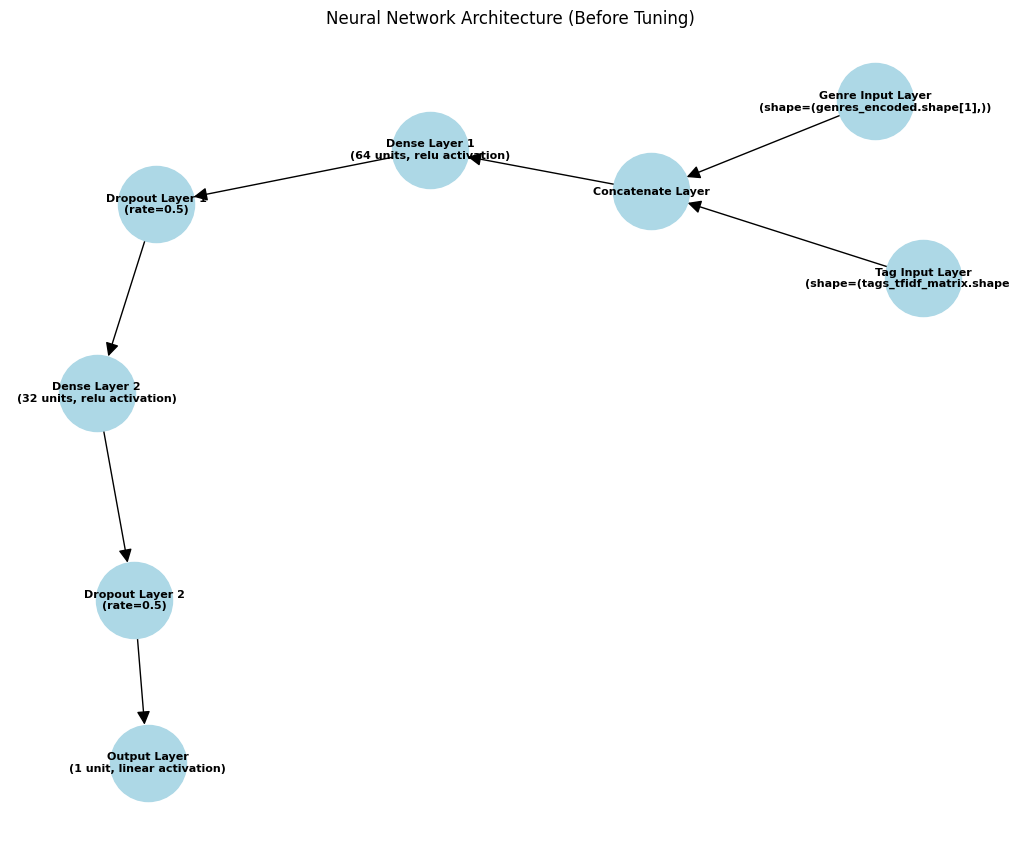

In [183]:
# Visualize Neural Network structure(before modifying) 
# Create a graph object
G = nx.DiGraph()

# Add nodes (represent layers)
G.add_node("Genre Input Layer\n(shape=(genres_encoded.shape[1],))")
G.add_node("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))")
G.add_node("Concatenate Layer")
G.add_node("Dense Layer 1\n(64 units, relu activation)")
G.add_node("Dropout Layer 1\n(rate=0.5)")
G.add_node("Dense Layer 2\n(32 units, relu activation)")
G.add_node("Dropout Layer 2\n(rate=0.5)")
G.add_node("Output Layer\n(1 unit, linear activation)")

# Add edges (represent flow of data)
G.add_edges_from([("Genre Input Layer\n(shape=(genres_encoded.shape[1],))", "Concatenate Layer"),
                  ("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))", "Concatenate Layer"),
                  ("Concatenate Layer", "Dense Layer 1\n(64 units, relu activation)"),
                  ("Dense Layer 1\n(64 units, relu activation)", "Dropout Layer 1\n(rate=0.5)"),
                  ("Dropout Layer 1\n(rate=0.5)", "Dense Layer 2\n(32 units, relu activation)"),
                  ("Dense Layer 2\n(32 units, relu activation)", "Dropout Layer 2\n(rate=0.5)"),
                  ("Dropout Layer 2\n(rate=0.5)", "Output Layer\n(1 unit, linear activation)")])

# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Generates the layout for the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=8, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title("Neural Network Architecture (Before Tuning)")
plt.show()


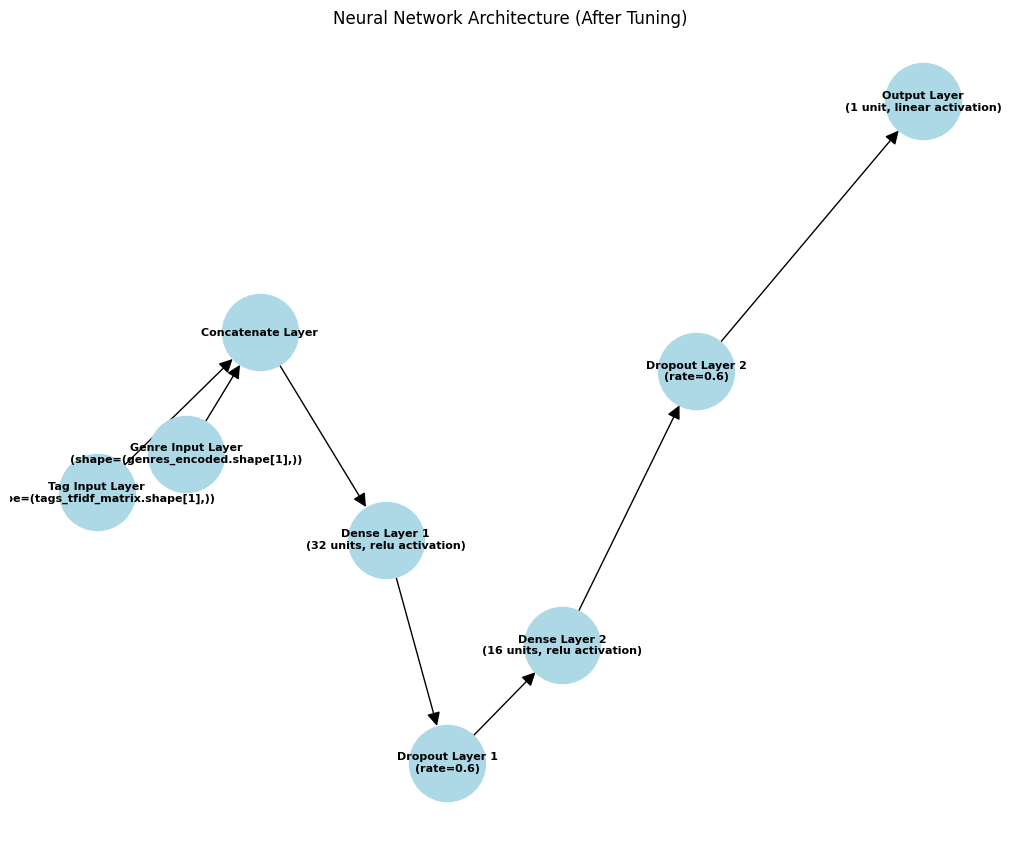

In [184]:
# Visualize Neural Network structure(after modifying) 

# Create a graph object
G = nx.DiGraph()

# Add nodes (represent layers)
G.add_node("Genre Input Layer\n(shape=(genres_encoded.shape[1],))")
G.add_node("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))")
G.add_node("Concatenate Layer")
G.add_node("Dense Layer 1\n(32 units, relu activation)")
G.add_node("Dropout Layer 1\n(rate=0.6)")
G.add_node("Dense Layer 2\n(16 units, relu activation)")
G.add_node("Dropout Layer 2\n(rate=0.6)")
G.add_node("Output Layer\n(1 unit, linear activation)")

# Add edges (represent flow of data)
G.add_edges_from([("Genre Input Layer\n(shape=(genres_encoded.shape[1],))", "Concatenate Layer"),
                  ("Tag Input Layer\n(shape=(tags_tfidf_matrix.shape[1],))", "Concatenate Layer"),
                  ("Concatenate Layer", "Dense Layer 1\n(32 units, relu activation)"),
                  ("Dense Layer 1\n(32 units, relu activation)", "Dropout Layer 1\n(rate=0.6)"),
                  ("Dropout Layer 1\n(rate=0.6)", "Dense Layer 2\n(16 units, relu activation)"),
                  ("Dense Layer 2\n(16 units, relu activation)", "Dropout Layer 2\n(rate=0.6)"),
                  ("Dropout Layer 2\n(rate=0.6)", "Output Layer\n(1 unit, linear activation)")])


# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Generates the layout for the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=8, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title("Neural Network Architecture (After Tuning)")
plt.show()


## 7. Recommendation Using the Neural Network

In [185]:
# Convert the tags_tfidf_matrix to an array outside of the function
tags_array = tags_tfidf_matrix.toarray()

def genre_tag_based_nn_recommendation(movie_title, merged_data_copy, genres_encoded, tags_array, model, n_recommendations=10):
    """
    Neural network-based movie recommendation system using genre and tag information, with robust input matching.
    
    Parameters:
    - movie_title (str): The title of the movie to search.
    - merged_data (DataFrame): The DataFrame containing the movie data with genre and tag features.
    - genre_db (np.array): The genre features of all movies (same order as merged_data).
    - tag_db (np.array): The tag features of all movies (same order as merged_data).
    - model (keras.Model): The trained neural network model.
    - n_recommendations (int): The number of movie recommendations to return.
    
    Returns:
    - recommended_movies (list of tuples): A list of recommended movie titles and their predicted scores.
    """
    
    # Find the closest matching movie title
    all_titles = merged_data['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find closest match
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")
    
    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data[merged_data['title'].str.lower() == matched_title]['title'].values[0]
    
    # Find the corresponding movie index
    movie_idx = merged_data[merged_data['title'] == original_matched_title].index[0]
    
    # Extract the genre and tag features for the input movie
    input_genre = genres_encoded[movie_idx].reshape(1, -1)  # Reshape to match model input
    input_tag = tags_array[movie_idx].reshape(1, -1)      # Reshape to match model input
    
    # Predict the scores for all movies in the database
    predicted_scores = model.predict([genres_encoded, tags_array], verbose=0).flatten()  # Predict for all movies
    
    # Sort the movies by predicted scores, excluding the input movie itself
    sorted_indices = np.argsort(predicted_scores)[::-1]  # Sort by scores in descending order
    
    # Collect top unique recommended movies
    recommended_movies = []
    seen_titles = set()  # To track unique movie titles
    
    for idx in sorted_indices:
        recommended_movie_title = merged_data.iloc[idx]['title']
        predicted_score = predicted_scores[idx]  # Get the predicted score
        
        # Skip duplicates and the original input movie itself
        if recommended_movie_title not in seen_titles and recommended_movie_title != original_matched_title:
            seen_titles.add(recommended_movie_title)
            recommended_movies.append((recommended_movie_title, predicted_score))
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    return recommended_movies[:n_recommendations]

# test this function
result_nn = genre_tag_based_nn_recommendation('frozen', merged_data_copy, genres_encoded, tags_array, model, n_recommendations=10)
result_nn

[('Fight Club (1999)', 5.057128),
 ('The Shawshank Redemption (1994)', 5.035028),
 ('Amelie (2001)', 5.0252724),
 ('The Place Promised in Our Early Days (2004)', 4.944762),
 ('Eternal Sunshine of the Spotless Mind (2004)', 4.9308624),
 ('Cloud Atlas (2012)', 4.921819),
 ('The Man from Earth (2007)', 4.9149456),
 ('Trainspotting (1996)', 4.907064),
 ('The Grand Budapest Hotel (2014)', 4.905074),
 ('Inception (2010)', 4.899391)]

After testing the second version of the neural network, an issue commonly referred to as *regression to the mean* was identified. Regardless of the input movie, the model consistently produced highly similar results, suggesting that it was settling on an "average" prediction rather than effectively learning and differentiating between the input features. This likely occurred because the model interpreted these generalized predictions as the optimal outcome within the given constraints.

To address this limitation, a more sophisticated approach will be explored by implementing a transformer model, specifically the *Sentence Transformer*. This model was selected after researching several alternatives on Hugging Face, where *Sentence Transformer* stood out due to its high ratings and memory efficiency, making it a suitable candidate for the next iteration. In the following phase, *Sentence Transformer* will be applied to build the next version of the system, **Recommendation System 2.0**.

# Transformer-Based Model Attempt (Recommendation System 2.0)

Following the unsatisfactory performance of the neural network models, where the recommendations often converged to similar results, the focus shifted toward a **transformer-based approach**. This approach aims to provide more nuanced and context-aware movie recommendations by leveraging pre-trained embeddings from **SentenceTransformer**.

## Embedding Generation with SentenceTransformer

In this version, the **`all-MiniLM-L6-v2`** model from the SentenceTransformer library was used to generate embeddings for movies based on their genres and tags. The embeddings capture the semantic meaning behind these features, enabling more accurate content-based recommendations.

The process involves generating two sets of embeddings:
- **Genre Embeddings**: Encoded using the SentenceTransformer model based on each movie's genre.
- **Tag Embeddings**: Similarly encoded based on the tags associated with each movie.

Both embeddings are then averaged to form a **combined embedding vector** for each movie, which is later used for cosine similarity comparisons during the recommendation process.


In [189]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

# Define a function to generate embedding vectors for movies
def generate_movie_embeddings(merged_data_copy, batch_size=16):
    # Start the timer for embedding generation
    embedding_start_time = time.time()

    genre_embeddings = model.encode(merged_data_copy['genres'].tolist(), batch_size=batch_size)  
    tag_embeddings = model.encode(merged_data_copy['tag'].tolist(), batch_size=batch_size)     
    
    # Combine genre and tag and average them
    combined_embeddings = (genre_embeddings + tag_embeddings) / 2

    # Embedding generation time
    embedding_end_time = time.time()
    print(f"Embeddings generated in {embedding_end_time - embedding_start_time:.2f} seconds")
    
    return combined_embeddings

# Generate movie embedding vectors
movie_embeddings = generate_movie_embeddings(merged_data_copy, batch_size=16)

# Check the shape
movie_embeddings.shape

Embeddings generated in 328.39 seconds


(126083, 384)

This step resulted in embedding vectors of shape `(126083, 384)`, indicating that each movie has a 384-dimensional vector capturing its genre and tag semantics.

## Content-Based Recommendations Using Embeddings
Once the embeddings were generated, a **cosine similarity** function was employed to compare the target movie's embedding with those of all other movies. This allowed for recommendations based on how closely aligned movies were in their semantic representation of genres and tags.

In [190]:
def recommend_movies_based_on_genre_and_tag(movie_title, merged_data_copy, movie_embeddings, n_recommendations=10):
    """
    Recommends movies based on embedding similarity using cosine similarity, searched by movie title.

    Parameters:
    movie_title (str): The title of the movie to search.
    merged_data_copy (DataFrame): The DataFrame containing the movie data.
    movie_embeddings (ndarray): The embedding matrix representing the movies.
    n_recommendations (int): The number of similar movie recommendations to return.

    Returns:
    A list of tuples with recommended movie titles and their corresponding similarity scores.
    """
    
    # Find the closest matching movie title and its corresponding movieId
    all_titles = merged_data_copy['title'].str.lower().tolist()  # Convert all titles to lowercase
    closest_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.5)  # Find the closest match
    
    if not closest_matches:
        raise ValueError(f"No movie found with a title similar to '{movie_title}'.")

    matched_title = closest_matches[0]
    
    # Get the original case-sensitive title
    original_matched_title = merged_data_copy[merged_data_copy['title'].str.lower() == matched_title]['title'].values[0]
    
    # Find the corresponding movie ID and index
    movie_id = merged_data_copy[merged_data_copy['title'] == original_matched_title]['movieId'].values[0]
    
    # Ensure the movie ID exists in the dataset
    if movie_id not in merged_data_copy['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found.")
    
    # Get the index and embedding vector of the target movie
    movie_idx = merged_data_copy[merged_data_copy['movieId'] == movie_id].index[0]
    movie_vector = movie_embeddings[movie_idx].reshape(1, -1)
    
    # Compute cosine similarity between the target movie and all others
    similarity_scores = cosine_similarity(movie_vector, movie_embeddings).flatten()
    
    # Get indices of top similar movies (excluding itself)
    similar_indices = similarity_scores.argsort()[::-1][1:]  # Get all similar movies, excluding the first one (itself)
    
    # Collect recommended movie titles with similarity scores
    recommended_movies = []
    seen_titles = set()  # To keep track of unique movie titles
    
    for idx in similar_indices:
        movie_title = merged_data_copy.iloc[idx]['title']
        similarity_score = similarity_scores[idx]  # Get the similarity score
        
        # Only add unique movie titles (skip duplicates and the original movie)
        if movie_title not in seen_titles and movie_title != original_matched_title:
            seen_titles.add(movie_title)
            recommended_movies.append((movie_title, similarity_score))  # Append as a tuple (title, score)
        
        # Stop when we have enough unique recommendations
        if len(recommended_movies) >= n_recommendations:
            break
    
    # If we don't have enough recommendations, we keep adding more similar ones
    while len(recommended_movies) < n_recommendations:
        for idx in similar_indices:
            movie_title = merged_data_copy.iloc[idx]['title']
            similarity_score = similarity_scores[idx]
            
            if movie_title not in seen_titles and movie_title != original_matched_title:
                seen_titles.add(movie_title)
                recommended_movies.append((movie_title, similarity_score))
            
            if len(recommended_movies) >= n_recommendations:
                break
    
    # Return exactly the requested number of recommendations
    return recommended_movies[:n_recommendations]

# Test the function
recommended_movies = recommend_movies_based_on_genre_and_tag('hello', merged_data_copy, movie_embeddings, n_recommendations=5)
recommended_movies

[('Flirting (1991)', 1.0),
 ('Butterfly (1982)', 1.0),
 ('The Last Temptation of Christ (1988)', 1.0),
 ('Restoration (1995)', 1.0),
 ('Do the Right Thing (1989)', 1.0)]

The output demonstrated semantically aligned recommendations, though further improvements were needed to ensure the results diversified across various inputs.

## Combining Genre/Tag-Based and Director-Based Recommendations

For a more comprehensive recommendation system, a function was developed to combine **content-based recommendations** (using embeddings) with **director-based suggestions**. The idea was to mix semantic similarities with directorial preferences to balance both content similarity and human-based creativity from directors.

In [191]:
def combined_recommendation_v2(movie_title_or_id, merged_data_copy, movie_embeddings, n_recommendations=5):
    """
    Combines recommendations based on movie embeddings (genres and tags) and director-based recommendations,
    without applying any specific weights to different recommendation sources.
    
    Parameters:
    movie_title_or_id (str or int): The title of the movie or user ID to search.
    merged_data_copy (DataFrame): The DataFrame containing the movie data.
    movie_embeddings (ndarray): The embedding matrix representing the movies.
    n_recommendations (int): The number of similar movie recommendations to return (default is 5).
    
    Returns:
    A list of recommended movie titles.
    """

    # Initialize variables to store recommendations
    genre_tag_similar_movies = []
    director_recommendations = []

    # Get genre and tag based recommendations (using embeddings)
    genre_tag_similar_movies = recommend_movies_based_on_genre_and_tag(movie_title_or_id, merged_data_copy, movie_embeddings, 10)

    # Get director-based recommendations if available (list of movie titles)
    director_recommendations = recommend_movies_by_director(movie_title_or_id, merged_data_copy, n_recommendations=2)

    # Combine recommendations (starting with director-based if available)
    combined_recommendations = []

    # Prioritize director recommendations (1 or 2 movies)
    num_director_movies = min(2, len(director_recommendations))  # Take 1 or 2 movies from director recommendations
    combined_recommendations.extend(director_recommendations[:num_director_movies])

    # Calculate the remaining number of movies to pick from genre and tag recommendations
    remaining_slots = n_recommendations - len(combined_recommendations)  # Remaining slots after picking director movies

    # Add movies from genre and tag recommendations (without duplicates)
    genre_tag_movies_to_add = [movie for movie, _ in genre_tag_similar_movies if movie.lower() not in [m.lower() for m in combined_recommendations]][:remaining_slots]
    combined_recommendations.extend(genre_tag_movies_to_add)

    # Return only the movie titles, ensuring there are exactly `n_recommendations`
    return combined_recommendations[:n_recommendations]

# Example usage:
result = combined_recommendation_v2('burning', merged_data_copy, movie_embeddings, n_recommendations=5)
result

['Friday the 13th Part V: A New Beginning (1985)',
 'Friday the 13th Part 3: 3D (1982)',
 'Friday the 13th Part IV: The Final Chapter (1984)',
 'Friday the 13th (2009)',
 'Halloween II (1981)']

In this combined approach:
- The first two recommendations are based on the movie's director.
- The remaining recommendations are generated using genre/tag embedding similarity.

## Gradio Interface for System 2.0
A new **Gradio Interface** was built to make the transformer-based recommendation system more accessible. Users can input either a movie title or a user ID to receive recommendations:
- **Movie Title**: The system uses the transformer-based embeddings to recommend semantically similar movies.
- **User ID**: The system falls back on the collaborative filtering (SVD-based) recommendation approach.
This simplified approach makes the interface easier for non-technical users, providing a "plug-and-play" recommendation experience.

In [192]:
def combined_user_and_movie_recommendation(user_input):
    """
    Combines recommendations based on user ID and movie title.
    If user input is an ID, it returns user-based recommendations.
    If user input is a movie title, it returns content-based recommendations.
    
    Parameters:
    user_input (str): User input, either a user ID or a movie title.
    
    Returns:
    A string with recommended movie titles or an error message if movie title not found.
    """
    try:
        # Try to parse the input as a user ID (integer)
        user_id = int(user_input)
        # Use SVD-based recommendation for user ID
        user_recommendations = get_user_based_recommendations(user_id, final_merged_data, best_svd, n_recommendations=5)
        return "\n".join(user_recommendations)
    
    except ValueError:
        # If the input is not a number, treat it as a movie title
        try:
            # Directly call combined_recommendation_v2 without converting or checking manually
            movie_recommendations = combined_recommendation_v2(user_input, merged_data_copy, movie_embeddings, n_recommendations=5)
            return "\n".join(movie_recommendations)
        except ValueError:
            # If combined_recommendation_v2 raises a ValueError, return "Oops"
            return "Oops, no movie found with a title similar to '{}'.".format(user_input)


# Create Gradio interface with a single input for user ID or movie title
interface = gr.Interface(
    fn=combined_user_and_movie_recommendation,
    inputs=gr.Textbox(label="Enter User ID or Movie Title"),
    outputs=gr.Textbox(label="Recommended Movies"),
    title="Charlotte's Movie Recommendation System 2.0",
    description="Enter a user ID for personalized recommendations, or a movie title for content-based recommendations."
)

# Launch the Gradio interface
interface.launch(share=True)


Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://468c3a8b1a3f80534c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### **Differences Between System 1.0 and System 2.0**

| Feature                               | System 1.0 (Weighted Genre/Tag)      | System 2.0 (Transformer-Based)     |
|---------------------------------------|--------------------------------------|------------------------------------|
| **Recommendation Method**             | Genre/Tag and Director with Weights  | Embeddings (Genre/Tag) and Director |
| **Customization**                     | Allows adjustment of genre/tag weights | Fixed, no weighting needed         |
| **Complexity**                        | More complex with weight sliders | Simpler, no weight adjustments    |
| **Recommendation Type**               | Combines genre/tag similarity with director-based suggestions | Embedding-based recommendations for more accurate content matching |
| **Intended Audience**                 | Users who want control over genre/tag weight | Simple, “plug-and-play” for all users |
| **Computational Efficiency**          | Slightly less efficient due to real-time weight adjustments | Efficient with pre-computed embeddings |
| **Semantic Search**                   | Limited, as weights affect relevance | Strong semantic matching through embeddings |

---

# **Final Summary**

Throughout this process, various recommendation methods were explored:

1. **Initial Neural Network Attempts**: These models combined collaborative filtering with content-based features (genres, tags, and directors). However, despite tuning efforts, they tended to converge toward average recommendations, suffering from *regression to the mean* and limited generalization.
   
2. **Transformer-Based System (2.0)**: By leveraging the **SentenceTransformer** model, semantic embeddings were generated for movies, capturing the underlying meaning of their genres and tags. The new model, using cosine similarity, was able to recommend movies that were semantically similar to the input movie. This improved recommendation diversity and accuracy.

3. **Gradio Interface**: Two versions of the recommendation system were implemented in a user-friendly interface:
   - **System 1.0**: Allows users to adjust weights between genre and tag preferences.
   - **System 2.0**: Offers a more straightforward recommendation system, using transformer-generated embeddings.

**Choosing the Right System**:
- **System 1.0** is best for users who prefer more control over recommendation weights, offering a balance between genres, tags, and director preferences.
- **System 2.0** is simpler and more efficient, relying on pre-trained transformer embeddings to provide context-aware recommendations without manual input adjustments.

Both systems fulfill the requirements of **semantic search**, as they aim to go beyond simple keyword matching by understanding the context and meaning of movie features. By using embeddings from a transformer model, the system captures deeper semantic relationships between movies, offering more accurate and meaningful recommendations.